
# Pré-Processamento: Aprendizagem Automática

## Objetivo
Para um dataset com o histórico de vendas semanais de diversos produtos, será necessário desenvolver uma função que divide os dados de vendas em diferentes dataframes, um para cada produto, criando e treinando dois modelos para um desses dataframes, um para receitas e outro para o nº de unidades vendidas, armazenando o modelo resultado (função Y=mx +b) e prevendo as receitas e o nº de unidades vendidas num ficheiro .csv, para dps este ficheiro ser consumido pelo método de otimização, permitindo que o mesmo usufrua das previsões obtidas. 

Deverão existir dois modelos por produto, um para prever as unidades vendidas no dia seguinte e outro para prever o lucro de vendas do dia seguinte. O período de vendas utilizado será diário ou semanal (a determinar), sendo esta escolha fruto de análise. É importante salientar que o modelo de otimização terá como objetivo otimizar as quantidades a ter em stock durante X semanas, sendo X um valor configurável que representa a periodicidade média de reabastecimento de stock por produto utilizado pela loja, sendo este período representado no mesmo intervalo temporal dos modelos, isto é, em dias ou semanas (a determinar).

In [38]:
%%capture
%pip install pandas
%pip install xlrd
%pip install openpyxl
%pip install unidecode
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install xgboost
%pip install tensorflow

In [106]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from numpy import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')



In [2]:


# Lemos o dataset
df = pd.read_csv('../dataset/sales.csv')

# Verificamos o dataset carregado
print(df.head(5))


C:\Users\reidp\AppData\Local\Temp\ipykernel_12136\467404470.py:2: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../dataset/sales.csv')


  product_id store_id        date  sales  revenue  stock  price promo_type_1  \
0      P0001    S0002  2017-01-02    0.0     0.00    8.0   6.25         PR14   
1      P0001    S0012  2017-01-02    1.0     5.30    0.0   6.25         PR14   
2      P0001    S0013  2017-01-02    2.0    10.59    0.0   6.25         PR14   
3      P0001    S0023  2017-01-02    0.0     0.00    6.0   6.25         PR14   
4      P0001    S0025  2017-01-02    0.0     0.00    1.0   6.25         PR14   

  promo_bin_1 promo_type_2 promo_bin_2  promo_discount_2 promo_discount_type_2  
0         NaN         PR03         NaN               NaN                   NaN  
1         NaN         PR03         NaN               NaN                   NaN  
2         NaN         PR03         NaN               NaN                   NaN  
3         NaN         PR03         NaN               NaN                   NaN  
4         NaN         PR03         NaN               NaN                   NaN  


In [3]:

# Verificamos o período do dataset
def revenue_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'dias')
    print(number_of_years, 'anos')
    
revenue_duration(df)


1091 dias
2.989041095890411 anos


In [4]:

# Verificamos que cada produto tem vários registos por dia, dado que para cada produto existem mais registos do que o total de dias acima ilustrado, sendo estes
# referentes às diferentes lojas em que foram vendidos. Porém, para efeitos de análise, iremos agrupar as vendas diárias de cada produto em todas as lojas numa só linha.
print(df['product_id'].value_counts().sort_values(ascending=False).head(15))



P0125    140997
P0364    140569
P0261    139651
P0333    139632
P0664    139486
P0390    139332
P0131    139014
P0536    138856
P0499    138228
P0116    137142
P0569    137132
P0372    136738
P0103    135841
P0642    134062
P0129    133990
Name: product_id, dtype: int64


In [5]:


# Verificamos as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



promo_bin_2              99.696317
promo_discount_2         99.696317
promo_discount_type_2    99.696317
promo_bin_1              86.370028
sales                     6.120647
dtype: float64

In [6]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_1'].value_counts().sort_values(ascending=False).head(15))



PR14    2092
Name: promo_type_1, dtype: int64


In [7]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_2'].value_counts().sort_values(ascending=False).head(15))



PR03    2092
Name: promo_type_2, dtype: int64


In [8]:


# Removemos as colunas cujas percentagens de inutilização são evidentemente superiores ao aceitável
df = df.drop(columns=["promo_bin_2", "promo_discount_2", "promo_discount_type_2", "promo_bin_1"])

# Removemos as colunas cuja distribuição é quase 100% para um determinado valor, dado que não terão impacto no modelo
df = df.drop(columns=["promo_type_1","promo_type_2"])
print(df.head(5))



  product_id store_id       date  sales  revenue  stock  price
0      P0001    S0002 2017-01-02    0.0     0.00    8.0   6.25
1      P0001    S0012 2017-01-02    1.0     5.30    0.0   6.25
2      P0001    S0013 2017-01-02    2.0    10.59    0.0   6.25
3      P0001    S0023 2017-01-02    0.0     0.00    6.0   6.25
4      P0001    S0025 2017-01-02    0.0     0.00    1.0   6.25


In [9]:


# Verificamos novamente as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



sales         6.120647
revenue       6.120647
stock         6.120647
price         2.940045
product_id    0.000000
dtype: float64

In [10]:


# Agrupamos as vendas semanais por produto, por semana.
# Para manter o preço diário de cada produto, como este pode variar de loja para loja, inferimos a média do preço diário de cada produto entre todas as lojas, embora à partida não seja utilizado.
df['year'] = df.date.dt.year.astype('Int64')
df['month'] = df.date.dt.month.astype('Int64')
df['week'] = df.date.dt.isocalendar().week.astype('Int64')
df2 = df.groupby(["product_id", "year", "week"]).agg({'sales': ['sum'], 'revenue': ['sum'], 'stock': ['sum'], 'price': ['mean']}).reset_index()
df2.columns = df2.columns.droplevel(1)
df2['date'] = df2.apply(lambda row: datetime.strptime(f'{row.year} {row.week} 1', '%G %V %u'), axis=1)

print(df2.head(15))



   product_id  year  week  sales  revenue   stock    price       date
0       P0001  2017     1   24.0   127.17  1318.0  6.25000 2017-01-02
1       P0001  2017     2   21.0   112.97  1174.0  6.31713 2017-01-09
2       P0001  2017     3   15.0    82.65  1040.0  6.50000 2017-01-16
3       P0001  2017     4    8.0    44.08   961.0  6.50000 2017-01-23
4       P0001  2017     5   12.0    66.12   904.0  6.50000 2017-01-30
5       P0001  2017     6   18.0    99.18   804.0  6.50000 2017-02-06
6       P0001  2017     7    5.0    27.55   742.0  6.50000 2017-02-13
7       P0001  2017     8    2.0    11.02   704.0  6.50000 2017-02-20
8       P0001  2017     9    7.0    38.57   661.0  6.50000 2017-02-27
9       P0001  2017    10   11.0    60.60   607.0  6.50000 2017-03-06
10      P0001  2017    11    7.0    38.57   473.0  6.50000 2017-03-13
11      P0001  2017    12    6.0    33.06   408.0  6.50000 2017-03-20
12      P0001  2017    13    4.0    22.04   367.0  6.50000 2017-03-27
13      P0001  2017 

In [11]:

# Verificamos novamente a quantidade de registos por produto, sendo que este valor deverá diminuir drasticamente face à análise igual feita anteriormente
# Assim, a quantidade agora deverá ser igual para todos os produtos, tendo como valor o total de semanas do dataset.
print(df2['product_id'].value_counts().sort_values(ascending=False).head(15))



P0001    156
P0571    156
P0613    156
P0611    156
P0609    156
P0608    156
P0602    156
P0599    156
P0591    156
P0590    156
P0587    156
P0585    156
P0583    156
P0579    156
P0574    156
Name: product_id, dtype: int64


In [12]:

# Verificamos novamente a quantidade de registos por produto, mas por ordem ascendente
print(df2['product_id'].value_counts().sort_values(ascending=True).head(15))


P0146    2
P0019    3
P0403    3
P0194    3
P0627    3
P0589    3
P0605    4
P0257    4
P0111    6
P0507    6
P0618    6
P0285    6
P0384    7
P0064    7
P0032    7
Name: product_id, dtype: int64


In [13]:

# Exportamos o Dataset já agrupado caso seja pretendido analisar os dados ao pormenor. (opcional)
#df2.to_csv('dataset/revenue_grouped.csv')



In [14]:


# Verificamos novamente as percentagens de dados em falta, já com as vendas agrupadas
percent_missing = df2.isnull().sum() * 100 / len(df2)
percent_missing.sort_values(ascending=False).head()



price         2.015328
product_id    0.000000
year          0.000000
week          0.000000
sales         0.000000
dtype: float64

In [15]:


# Dividimos o dataframe por produto, dado que irá ser treinado um modelo de previsão para cada um.
dfByProdList = df2.groupby("product_id")

print(len(dfByProdList))

    

649


In [16]:

# Para efeitos de análise, iremos inicialmente começar por criar um modelo somente para alguns produtos de teste.
product_df_Test1 = dfByProdList.get_group('P0001')
product_df_Test2 = dfByProdList.get_group('P0748')
product_df_Test3 = dfByProdList.get_group('P0125')
print(product_df_Test1.head())



  product_id  year  week  sales  revenue   stock    price       date
0      P0001  2017     1   24.0   127.17  1318.0  6.25000 2017-01-02
1      P0001  2017     2   21.0   112.97  1174.0  6.31713 2017-01-09
2      P0001  2017     3   15.0    82.65  1040.0  6.50000 2017-01-16
3      P0001  2017     4    8.0    44.08   961.0  6.50000 2017-01-23
4      P0001  2017     5   12.0    66.12   904.0  6.50000 2017-01-30


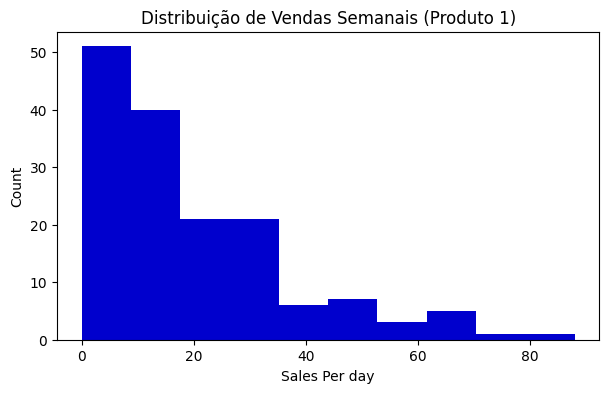

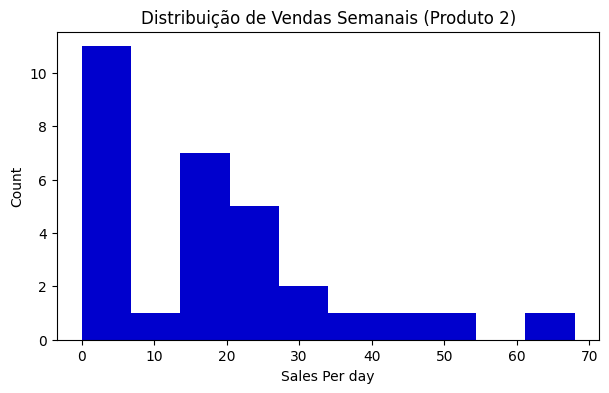

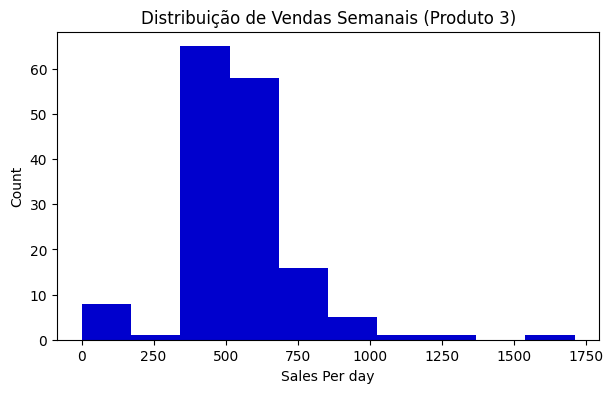

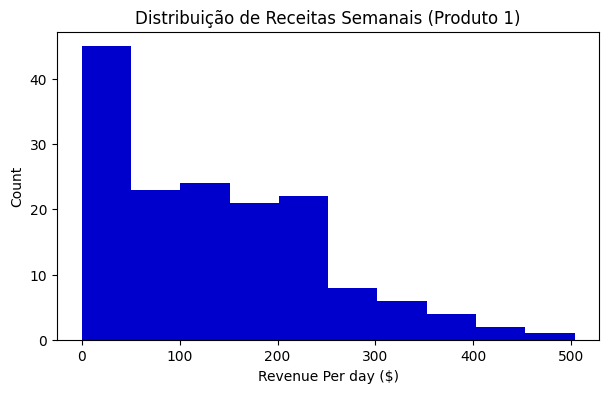

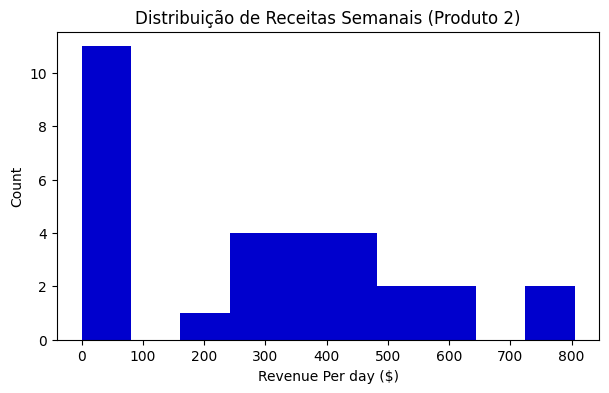

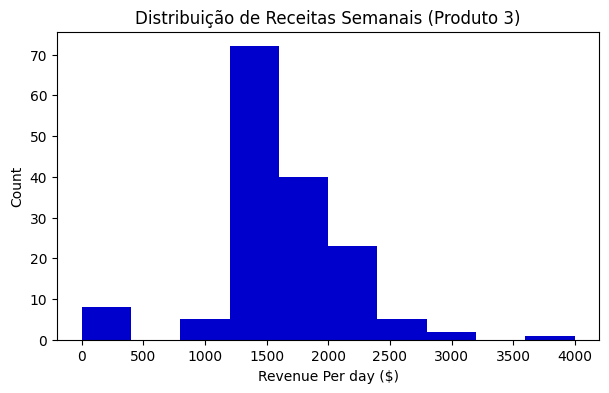

In [17]:


# Verificamos a distribuição de vendas semanais para os produtos de teste
def sales_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day", ylabel = "Count", title = title)
    
def revenue_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.revenue, color='mediumblue')
    
    ax.set(xlabel = "Revenue Per day ($)", ylabel = "Count", title = title )


sales_per_day(product_df_Test1, "Distribuição de Vendas Semanais (Produto 1)")
sales_per_day(product_df_Test2, "Distribuição de Vendas Semanais (Produto 2)")
sales_per_day(product_df_Test3, "Distribuição de Vendas Semanais (Produto 3)")
revenue_per_day(product_df_Test1, "Distribuição de Receitas Semanais (Produto 1)")
revenue_per_day(product_df_Test2, "Distribuição de Receitas Semanais (Produto 2)")
revenue_per_day(product_df_Test3, "Distribuição de Receitas Semanais (Produto 3)")




In [18]:


# Verificamos a média de vendas e receitas semanais
avg_monthly_sales1 = product_df_Test1.sales.mean()
avg_monthly_sales2 = product_df_Test2.sales.mean()
avg_monthly_sales3 = product_df_Test3.sales.mean()
avg_monthly_revenue1 = product_df_Test1.revenue.mean()
avg_monthly_revenue2 = product_df_Test2.revenue.mean()
avg_monthly_revenue3 = product_df_Test3.revenue.mean()
print(f"Média de vendas semanais (Produto 1): {avg_monthly_sales1}")
print(f"Média de vendas semanais (Produto 2): {avg_monthly_sales2}")
print(f"Média de vendas semanais (Produto 3): {avg_monthly_sales3}")
print(f"Média de receitas semanais (Produto 1): ${avg_monthly_revenue1}")
print(f"Média de receitas semanais (Produto 2): ${avg_monthly_revenue2}")
print(f"Média de receitas semanais (Produto 3): ${avg_monthly_revenue3}")



Média de vendas semanais (Produto 1): 19.03205128205128
Média de vendas semanais (Produto 2): 17.466666666666665
Média de vendas semanais (Produto 3): 537.4551282051282
Média de receitas semanais (Produto 1): $135.43871794871794
Média de receitas semanais (Produto 2): $276.73333333333335
Média de receitas semanais (Produto 3): $1606.9859615384614


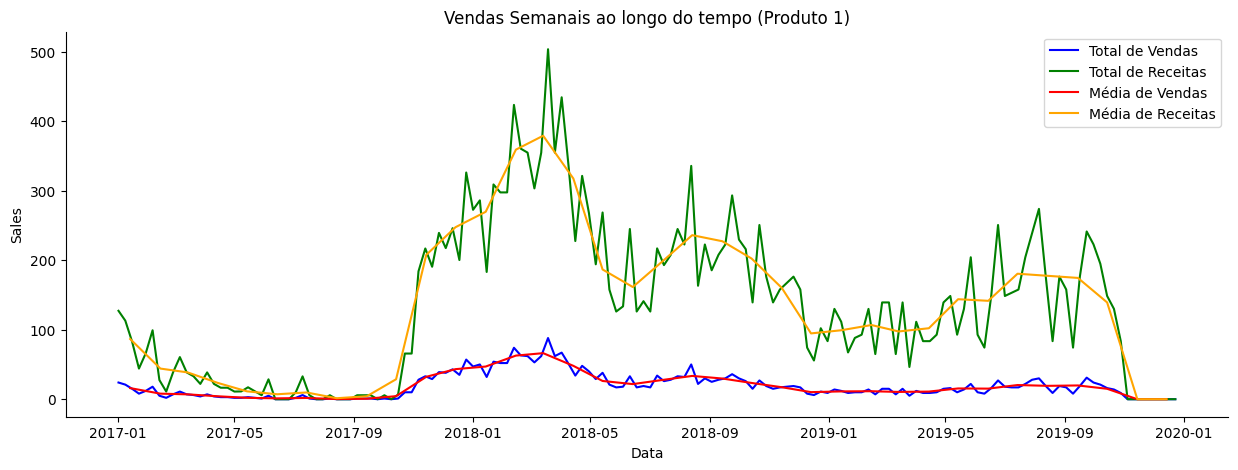

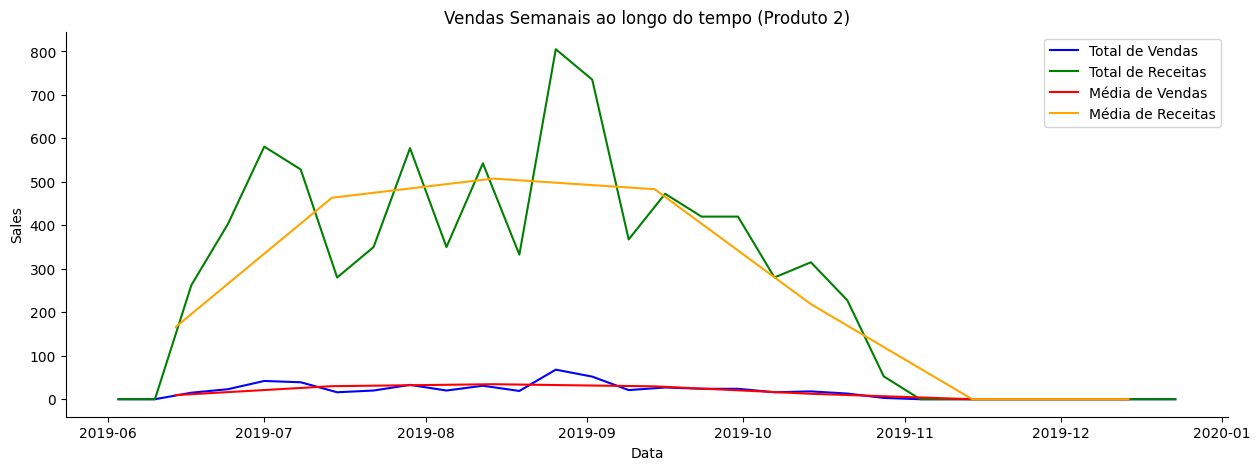

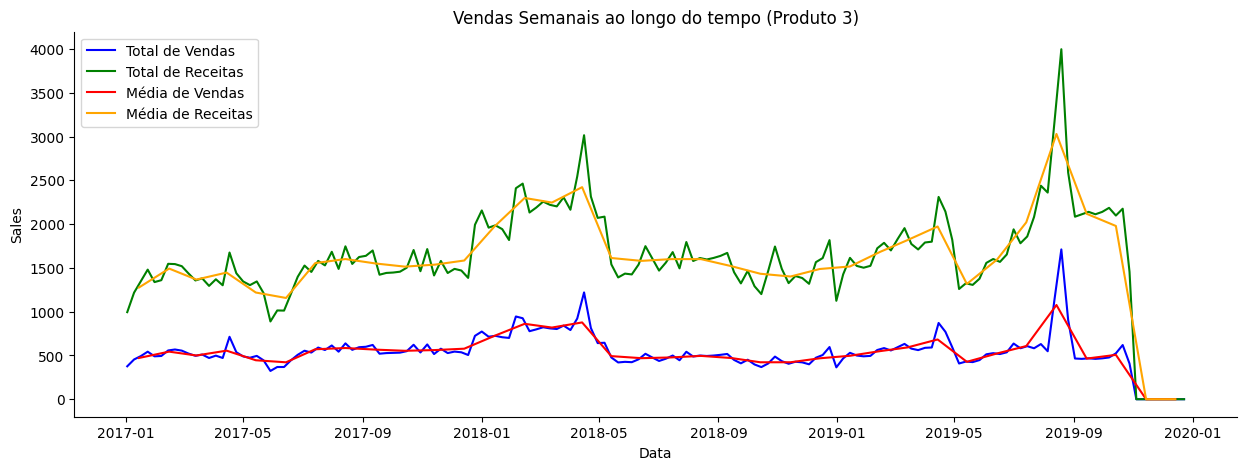

In [19]:

# Esta função permite verificar a Estacionariedade de um dataframe, permitindo aferir se os seus dados são estacionários ou não, sendo que 
# uma série temporal é considerada estacionária se a média, a variância e a autocorrelação forem constantes ao longo do tempo.
def time_plot(data, sales_col, rev_col, title, checkStationarity=True, checkForecasted=False):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x = 'date', y = sales_col, data=data, ax=ax, color='blue', label='Total de Vendas')
    sns.lineplot(x = 'date', y = rev_col, data=data, ax=ax, color='green', label='Total de Receitas') 
    
    if checkStationarity:
        stationary_sales = data.copy()
        stationary_sales.date = stationary_sales.date.dt.to_period('M')
        stationary_sales = stationary_sales.groupby(stationary_sales.date)[sales_col].mean().reset_index()
        stationary_sales.date = pd.to_datetime(stationary_sales.date.astype(str), format='%Y-%m')
        sns.lineplot(x = (stationary_sales.date  + timedelta(3*52/12)), y = sales_col, data=stationary_sales, ax=ax, color='red', label='Média de Vendas')

        stationary_revenue = data.copy()
        stationary_revenue.date = stationary_revenue.date.dt.to_period('M')
        stationary_revenue = stationary_revenue.groupby(stationary_revenue.date)[rev_col].mean().reset_index()
        stationary_revenue.date = pd.to_datetime(stationary_revenue.date.astype(str), format='%Y-%m')
        sns.lineplot(x = (stationary_revenue.date  + timedelta(3*52/12)), y = rev_col, data=stationary_revenue, ax=ax, color='orange', label='Média de Receitas')

    if checkForecasted:
        sns.lineplot(x = 'date', y = 'forecasted_sales', data=data, ax=ax, color='yellow', label='Total de Vendas Previstas')
        sns.lineplot(x = 'date', y = 'forecasted_revenue', data=data, ax=ax, color='orange', label='Total de Receitas Previstas') 

    ax.set(xlabel = "Data", ylabel = "Sales", title = title)
    
    sns.despine()
    
# Verificamos o histórico de vendas semanais dos produtos ao longo do tempo, juntamente com uma análise da Estacionariedade dos dados
time_plot(product_df_Test1, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)')
time_plot(product_df_Test2, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)')
time_plot(product_df_Test3, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)')



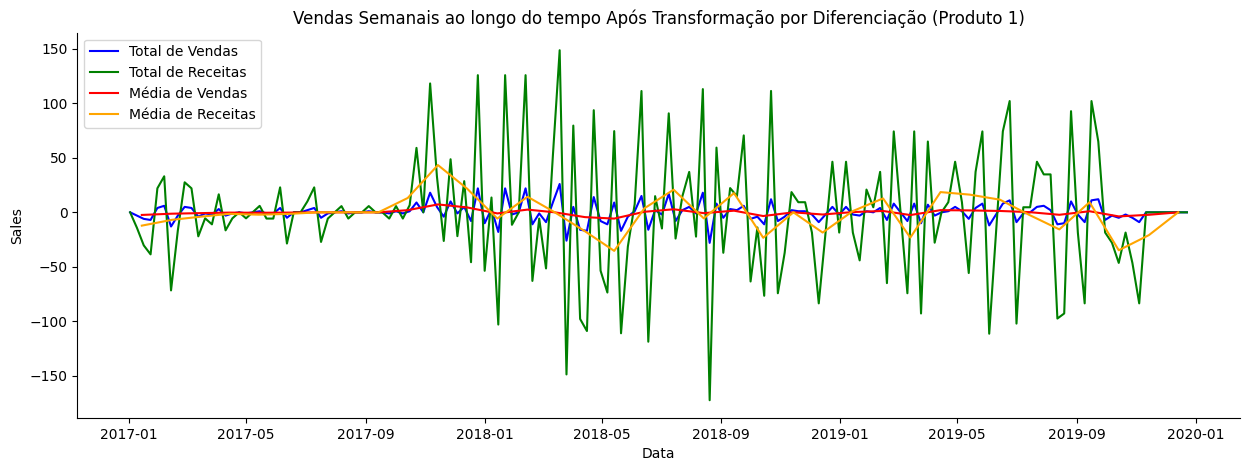

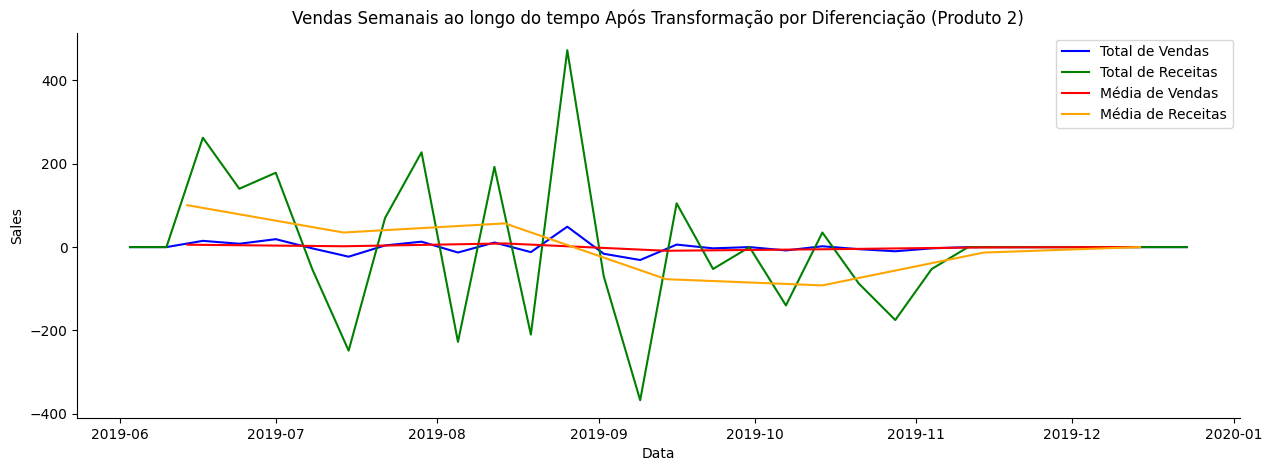

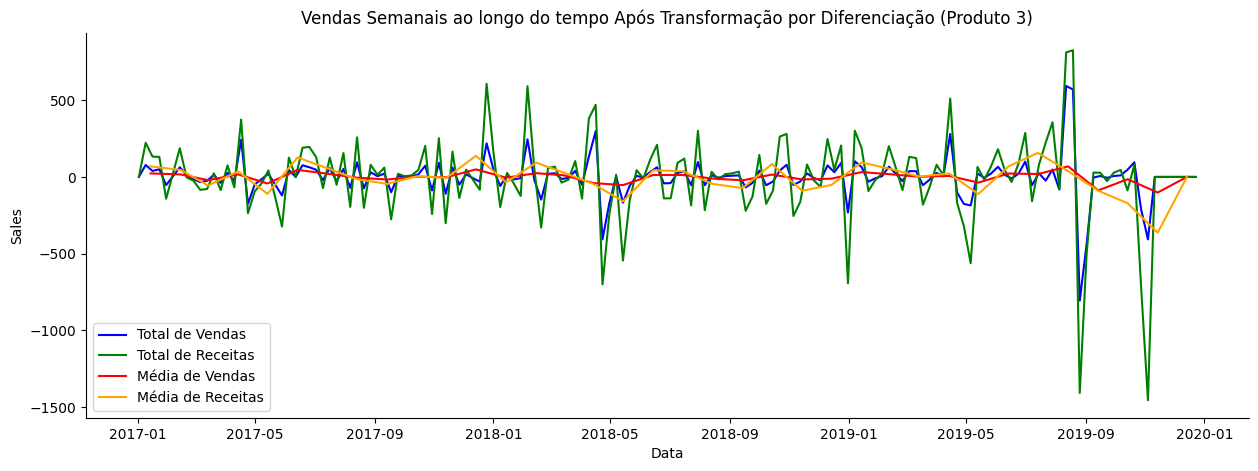

In [20]:


# Função para aplicar diferenciação a um dataframe, sendo esta uma técnica comumente utilizada para lidar com dados de séries temporais que não são estacionários
def get_diff(data):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    data1 = data.copy()

    data1['sales_diff'] = data1.sales.diff()
    data1['revenue_diff'] = data1.revenue.diff()
    data1['sales_diff'] = data1['sales_diff'].fillna(0)
    data1['revenue_diff'] = data1['revenue_diff'].fillna(0)

    return data1

product_df_Test1_afterDiff = get_diff(product_df_Test1)
product_df_Test2_afterDiff = get_diff(product_df_Test2)
product_df_Test3_afterDiff = get_diff(product_df_Test3)

# Verificamos a diferença após aplicar a transformação por diferenciação
time_plot(product_df_Test1_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 1)')
time_plot(product_df_Test2_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 2)')
time_plot(product_df_Test3_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 3)')




In [21]:


# Função para Deteção de outliers recorrendo a Tukey IQR
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values



In [22]:


# Verificamos se existem outliers a ter em consideração
tukey_values_sales1 = find_outliers_tukey(product_df_Test1['sales'])
tukey_values_sales2 = find_outliers_tukey(product_df_Test2['sales'])
tukey_values_sales3 = find_outliers_tukey(product_df_Test3['sales'])
tukey_values_revenue1 = find_outliers_tukey(product_df_Test1['revenue'])
tukey_values_revenue2 = find_outliers_tukey(product_df_Test2['revenue'])
tukey_values_revenue3 = find_outliers_tukey(product_df_Test3['revenue'])
print(f"Outliers das Vendas (Produto 1):\n {np.sort(tukey_values_sales1)}\n")
print(f"Outliers das Vendas (Produto 2):\n {np.sort(tukey_values_sales2)}\n")
print(f"Outliers das Vendas (Produto 3):\n {np.sort(tukey_values_sales3)}\n")
print(f"Outliers das Receitas (Produto 1):\n {np.sort(tukey_values_revenue1)}\n")
print(f"Outliers das Receitas (Produto 2):\n {np.sort(tukey_values_revenue2)}\n")
print(f"Outliers das Receitas (Produto 3):\n {np.sort(tukey_values_revenue3)}\n")



Outliers das Vendas (Produto 1):
 [[58. 59. 60. 62. 63. 64. 65.]
 [62. 62. 62. 63. 67. 74. 88.]]

Outliers das Vendas (Produto 2):
 [[7.0442e+04]
 [6.8000e+01]]

Outliers das Vendas (Produto 3):
 [[10653. 10654. 10656. 10657. 10658. 10659. 10660. 10662. 10663. 10664.
  10715. 10732. 10733. 10734. 10744. 10745. 10746. 10747. 10748. 10749.
  10750. 10751.]
 [    0.     0.     0.     0.     0.     0.     0.     0.   798.   802.
    809.   813.   822.   841.   871.   905.   922.   925.   945.  1141.
   1220.  1711.]]

Outliers das Receitas (Produto 1):
 [[ 63.  ]
 [503.36]]

Outliers das Receitas (Produto 2):
 []

Outliers das Receitas (Produto 3):
 [[10662.   10663.   10732.   10733.   10734.   10744.   10745.   10746.
  10747.   10748.   10749.   10750.   10751.  ]
 [    0.       0.       0.       0.       0.       0.       0.       0.
   2545.41  2589.73  3015.44  3171.78  3997.77]]



In [23]:


# Verificamos se existem valores em falta para estes produtos
percent_missing1 = product_df_Test1.isnull().sum()
print(percent_missing1.sort_values(ascending=False).head())
percent_missing2 = product_df_Test2.isnull().sum()
print(percent_missing2.sort_values(ascending=False).head())
percent_missing3 = product_df_Test3.isnull().sum()
print(percent_missing3.sort_values(ascending=False).head())


product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64
product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64
product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64


In [24]:

# Função de preparação pré-previsão, sendo que esta foi separada para poder ser melhorada após análise do desempenho dos modelos obtidos
def prepareBeforePredict(dataframe):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    dataframe1 = dataframe.copy()

    # Criamos uma nova coluna com o nº de vendas e receitas da semana imediatamente anterior
    dataframe1['prev_sales'] = dataframe1['sales'].shift(1)
    dataframe1['prev_revenue'] = dataframe1['revenue'].shift(1)

    # Preenchemos a primeira linha com o valor 0, dado que não existe registo anterior
    dataframe1['prev_sales'] = dataframe1['prev_sales'].fillna(0)
    dataframe1['prev_revenue'] = dataframe1['prev_revenue'].fillna(0)
    dataframe1 = dataframe1.astype({'sales':'int', 'prev_sales':'int', 'revenue':'int', 'prev_revenue':'int'})

    return dataframe1

# Verificamos o resultado da preparação
print(prepareBeforePredict(product_df_Test1).head())

  product_id  year  week  sales  revenue   stock    price       date  \
0      P0001  2017     1     24      127  1318.0  6.25000 2017-01-02   
1      P0001  2017     2     21      112  1174.0  6.31713 2017-01-09   
2      P0001  2017     3     15       82  1040.0  6.50000 2017-01-16   
3      P0001  2017     4      8       44   961.0  6.50000 2017-01-23   
4      P0001  2017     5     12       66   904.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  
0           0             0  
1          24           127  
2          21           112  
3          15            82  
4           8            44  


In [25]:


# Função para prever o total de vendas ou receitas para as últimas n semanas, sendo n a periodicidade de reposicionamento de stock esperada, em semanas.
# Esta função recebe o modelo já treinado e o conjunto total de vendas ou receitas, sendo este necessário para que sejam obtidas as últimas n semanas.
def predict_total_in_last_n_weeks(model, X, n):
    if n == 0:
        return 0
    X_PeriodicityTest = X[-n:]
    y_PeriodicityPred = model.predict(X_PeriodicityTest)
    return sum(y_PeriodicityPred)


# Função de previsão, devolvendo as métricas de avaliação de desempenho dos modelos obtidos
def find_model_perf(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos o MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculamos o RMSE
    rmse = sqrt(mse)

    # Calculamos o MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculamos o R^2 score
    r2 = r2_score(y_test, y_pred)

    return y_pred, rmse, mae, r2


# Função total de previsão, recorrendo às funções de preparação e previsão
def predict(dataframe, model, salesColsToDrop, revenueColsToDrop, periodicity=0):
    # Removemos as colunas que não deverão ser utilizadas pelo modelo, sendo que estas poderão variar caso tenham sido aplicadas técnicas de otimização ao dataframe
    X_sales = dataframe.drop(columns = salesColsToDrop, axis = 1)
    y_sales = dataframe.sales
    X_revenue = dataframe.drop(columns = revenueColsToDrop, axis = 1)
    y_revenue = dataframe.revenue
        
    X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, train_size=0.7, random_state=1)
    X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, train_size=0.7, random_state=1)

    y_pred_sales, rmse_sales, mae_sales, r2_sales = find_model_perf(X_train_sales, y_train_sales, X_test_sales, y_test_sales, model)
    periodicity_total_pred_sales = predict_total_in_last_n_weeks(model, X_sales, periodicity)

    y_pred_revenue, rmse_revenue, mae_revenue, r2_revenue = find_model_perf(X_train_revenue, y_train_revenue, X_test_revenue, y_test_revenue, model)
    periodicity_total_pred_revenue = predict_total_in_last_n_weeks(model, X_revenue, periodicity)

    # Armazenamos os índices dos conjuntos de teste
    test_sales_index = X_test_sales.index
    test_revenue_index = X_test_revenue.index

    # Adicionamos os indíces aos valores previstos
    y_pred_sales_df = pd.DataFrame(y_pred_sales, index = test_sales_index, columns=['forecasted_sales'])
    y_pred_revenue_df = pd.DataFrame(y_pred_revenue, index = test_revenue_index, columns=['forecasted_revenue'])
    
    # Juntamos o dataframe original com o dataframe de valores previstos
    dataframe_with_forecast= pd.merge(dataframe, y_pred_sales_df, left_index=True, right_index=True, how='outer')
    dataframe_with_forecast = pd.merge(dataframe_with_forecast, y_pred_revenue_df, left_index=True, right_index=True, how='outer')

    return rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, dataframe_with_forecast, periodicity_total_pred_sales, periodicity_total_pred_revenue



In [26]:

# Função de preparação pré-previsão com aplicação de técnicas de otimização, nomeadamente a técnica de transformação por diferenciação
def prepareBeforePredictOptimized(dataframe):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    dataframe1 = dataframe.copy()

    # Colocamos os valores numéricos como inteiros
    dataframe1 = dataframe1.astype({'sales':'int', 'revenue':'int'})

    # Criamos uma nova coluna com o nº de vendas e receitas da semana imediatamente anterior
    dataframe1['prev_sales'] = dataframe1['sales'].shift(1)
    dataframe1['prev_revenue'] = dataframe1['revenue'].shift(1)

    # Aplicamos a técnica de transformação por diferenciação
    dataframe1['diff_sales'] = dataframe1['sales'].diff()
    dataframe1['diff_revenue'] = dataframe1['revenue'].diff()

    # Preenchemos a primeira linha com o valor 0, dado que não existe registo anterior
    dataframe1['prev_sales'] = dataframe1['prev_sales'].fillna(0)
    dataframe1['prev_revenue'] = dataframe1['prev_revenue'].fillna(0)
    dataframe1['diff_sales'] = dataframe1['diff_sales'].fillna(0)
    dataframe1['diff_revenue'] = dataframe1['diff_revenue'].fillna(0)

    return dataframe1


# Verificamos o resultado da preparação otimizada
print(prepareBeforePredictOptimized(product_df_Test1).head())

  product_id  year  week  sales  revenue   stock    price       date  \
0      P0001  2017     1     24      127  1318.0  6.25000 2017-01-02   
1      P0001  2017     2     21      112  1174.0  6.31713 2017-01-09   
2      P0001  2017     3     15       82  1040.0  6.50000 2017-01-16   
3      P0001  2017     4      8       44   961.0  6.50000 2017-01-23   
4      P0001  2017     5     12       66   904.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  diff_sales  diff_revenue  
0         0.0           0.0         0.0           0.0  
1        24.0         127.0        -3.0         -15.0  
2        21.0         112.0        -6.0         -30.0  
3        15.0          82.0        -7.0         -38.0  
4         8.0          44.0         4.0          22.0  


In [72]:
def predict_model_no_opt(model):
    salesColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue']
    revenueColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales']

    # Verificamos a variação do desempenho dos modelos de previsão em alguns produtos diferentes
    product_df_Test1_prep = prepareBeforePredict(product_df_Test1)
    product_df_Test2_prep = prepareBeforePredict(product_df_Test2)
    product_df_Test3_prep = prepareBeforePredict(product_df_Test3)
    rmse_sales1, rmse_revenue1, mae_sales1, mae_revenue1, r2_sales1, r2_revenue1, dataframe_with_forecast1,_,_ = predict(product_df_Test1_prep, model, salesColsToDrop, revenueColsToDrop)
    rmse_sales2, rmse_revenue2, mae_sales2, mae_revenue2, r2_sales2, r2_revenue2, dataframe_with_forecast2,_,_ = predict(product_df_Test2_prep, model, salesColsToDrop, revenueColsToDrop)
    rmse_sales3, rmse_revenue3, mae_sales3, mae_revenue3, r2_sales3, r2_revenue3, dataframe_with_forecast3,_,_ = predict(product_df_Test3_prep, model, salesColsToDrop, revenueColsToDrop)

    print(f"RMSE das Vendas (Produto 1): {rmse_sales1}")
    print(f"RMSE das Vendas (Produto 2): {rmse_sales2}")
    print(f"RMSE das Vendas (Produto 3): {rmse_sales3}")
    print(f"Média RMSE das Vendas: {(rmse_sales1 + rmse_sales2 + rmse_sales3)/3}")
    print(f"\nRMSE das Receitas (Produto 1): {rmse_revenue1}")
    print(f"RMSE das Receitas (Produto 2): {rmse_revenue2}")
    print(f"RMSE das Receitas (Produto 3): {rmse_revenue3}")
    print(f"Média RMSE das Receitas: {(rmse_revenue1 + rmse_revenue2 + rmse_revenue3)/3}")
    print(f"\nMAE das Vendas (Produto 1): {mae_sales1}")
    print(f"MAE das Vendas (Produto 2): {mae_sales2}")
    print(f"MAE das Vendas (Produto 3): {mae_sales3}")
    print(f"Média MAE das Vendas: {(mae_sales1 + mae_sales2 + mae_sales3)/3}")
    print(f"\nMAE das Receitas (Produto 1): {mae_revenue1}")
    print(f"MAE das Receitas (Produto 2): {mae_revenue2}")
    print(f"MAE das Receitas (Produto 3): {mae_revenue3}")
    print(f"Média MAE das Receitas: {(mae_revenue1 + mae_revenue2 + mae_revenue3)/3}")
    print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
    print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
    print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
    print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
    print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
    print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
    print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
    print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")
    time_plot(dataframe_with_forecast1.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)', False, True)
    time_plot(dataframe_with_forecast2.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)', False, True)
    time_plot(dataframe_with_forecast3.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)', False, True)


In [73]:
def predict_model_opt(model):
    salesColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue', 'diff_revenue']
    revenueColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales', 'diff_sales']

    # Verificamos a diferença do desempenho dos modelos de previsão após aplicação de técnicas de otimização
    product_df_Test1_prep = prepareBeforePredictOptimized(product_df_Test1)
    product_df_Test2_prep = prepareBeforePredictOptimized(product_df_Test2)
    product_df_Test3_prep = prepareBeforePredictOptimized(product_df_Test3)
    _, _, _, _, r2_sales1, r2_revenue1, dataframe_with_forecast1_opt,_,_ = predict(product_df_Test1_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)
    _, _, _, _, r2_sales2, r2_revenue2, dataframe_with_forecast2_opt,_,_ = predict(product_df_Test2_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)
    _, _, _, _, r2_sales3, r2_revenue3, dataframe_with_forecast3_opt,_,_ = predict(product_df_Test3_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)

    print(f"---Após Otimização---")
    print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
    print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
    print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
    print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
    print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
    print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
    print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
    print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")
    time_plot(dataframe_with_forecast1_opt.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)', False, True)
    time_plot(dataframe_with_forecast2_opt.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)', False, True)
    time_plot(dataframe_with_forecast3_opt.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)', False, True)

In [80]:
def pred_model_overall(model):
    salesColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue']
    revenueColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales']
    salesColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue', 'diff_revenue']
    revenueColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales', 'diff_sales']
    
    # Criamos um dataframe onde serão armazenados os resultados dos modelos obtidos para posterior análise/comparação
    modelResults = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])
    modelResults_optimized = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])

    # Iteramos a lista de dataframes, treinando um modelo para cada produto e armazenando os respetivos resultados
    for name, group in dfByProdList:
        group_prep = prepareBeforePredict(group)
        group_prep_optimized = prepareBeforePredictOptimized(group)
        
        if(len(group_prep.sales.unique()) > 4) & (len(group_prep.revenue.unique()) > 4):
            rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue,_,_,_ = predict(group_prep, model, salesColsToDrop, revenueColsToDrop)

            modelResults = pd.concat([modelResults,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, 
                "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])

            rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue,_,_,_ = predict(group_prep_optimized, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)

            modelResults_optimized = pd.concat([modelResults_optimized,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, 
                "mae_sales": mae_sales, "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])
        

    print(modelResults.head())
    print(modelResults_optimized.head())
    
                
    return modelResults,modelResults_optimized

In [105]:
def print_model_results_no_opt(modelResults):
    # Verificamos a média do desempenho dos modelos para todos os produtos válidos (com dados suficientes para prever)
    print(f"---Antes Otimização---")
    print(f"Média RMSE de Receitas: {modelResults[modelResults['r2_sales'] > -1].rmse_sales.mean()}")
    print(f"Média RMSE de Vendas: {modelResults[modelResults['r2_revenue'] > -1].rmse_revenue.mean()}")
    print(f"Média MAE de Receitas: {modelResults[modelResults['r2_sales'] > -1].mae_sales.mean()}")
    print(f"Média MAE de Vendas: {modelResults[modelResults['r2_revenue'] > -1].mae_revenue.mean()}")
    print(f"Média R2 Score  de Vendas: {modelResults[modelResults['r2_sales'] > -1].r2_sales.mean()}")
    print(f"Média R2 Score de Receitas: {modelResults[modelResults['r2_revenue'] > -1].r2_revenue.mean()}")


In [82]:
def print_model_results_opt(modelResults_optimized):
    # Verificamos a média do desempenho dos modelos para todos os produtos válidos, após aplicação de técnicas de otimização
    print(f"---Após Otimização---")
    print(f"Média RMSE de Receitas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].rmse_sales.mean()}")
    print(f"Média RMSE de Vendas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].rmse_revenue.mean()}")
    print(f"Média MAE de Receitas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].mae_sales.mean()}")
    print(f"Média MAE de Vendas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].mae_revenue.mean()}")
    print(f"Média R2 Score de Vendas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].r2_sales.mean()}")
    print(f"Média R2 Score de Receitas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].r2_revenue.mean()}")


In [85]:

def r2_distribution_sales(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_sales, color='mediumblue')
    
    ax.set(xlabel = "R2 Score", ylabel = "Count", title = title )

def r2_distribution_revenue(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_revenue, color='mediumblue')
    
    ax.set(xlabel = "R2 Score", ylabel = "Count", title = title )

In [86]:
def print_plot_results(modelResults,modelResults_optimized):
    # Verificamos a distribuição do R2 Score de todos os modelos obtidos
    r2_distribution_sales(modelResults[modelResults['r2_sales'] > -1], "Distribuição de R2 Score de Vendas")
    r2_distribution_revenue(modelResults[modelResults['r2_revenue'] > -1], "Distribuição de R2 Score de Receitas")

    # Verificamos a distribuição do R2 Score de todos os modelos obtidos, após aplicação de técnicas de otimização
    r2_distribution_sales(modelResults_optimized[modelResults_optimized['r2_sales'] > -1], "Distribuição de R2 Score de Vendas (Após Otimização)")
    r2_distribution_revenue(modelResults_optimized[modelResults_optimized['r2_revenue'] > -1], "Distribuição de R2 Score de Receitas (Após Otimização)")


#  LINEAR REGRESSION

In [74]:
model = LinearRegression()

RMSE das Vendas (Produto 1): 8.640077207201996
RMSE das Vendas (Produto 2): 8.575068222135721
RMSE das Vendas (Produto 3): 138.5473307892559
Média RMSE das Vendas: 51.92082540619788

RMSE das Receitas (Produto 1): 60.38975823560935
RMSE das Receitas (Produto 2): 126.30790640213402
RMSE das Receitas (Produto 3): 338.2480214469991
Média RMSE das Receitas: 174.9818953615808

MAE das Vendas (Produto 1): 6.25855579541628
MAE das Vendas (Produto 2): 6.18326878500514
MAE das Vendas (Produto 3): 74.95429922592834
Média MAE das Vendas: 29.132041268783254

MAE das Receitas (Produto 1): 45.07726375362054
MAE das Receitas (Produto 2): 98.09552063553636
MAE das Receitas (Produto 3): 192.85253816282085
Média MAE das Receitas: 112.00844085065926

R2 Score das Vendas (Produto 1): 0.773316736595319
R2 Score das Vendas (Produto 2): 0.36583524316899163
R2 Score das Vendas (Produto 3): 0.37957831050455804
Média R2 Score das Vendas: 0.5062434300896229

R2 Score das Receitas (Produto 1): 0.708043265358177
R

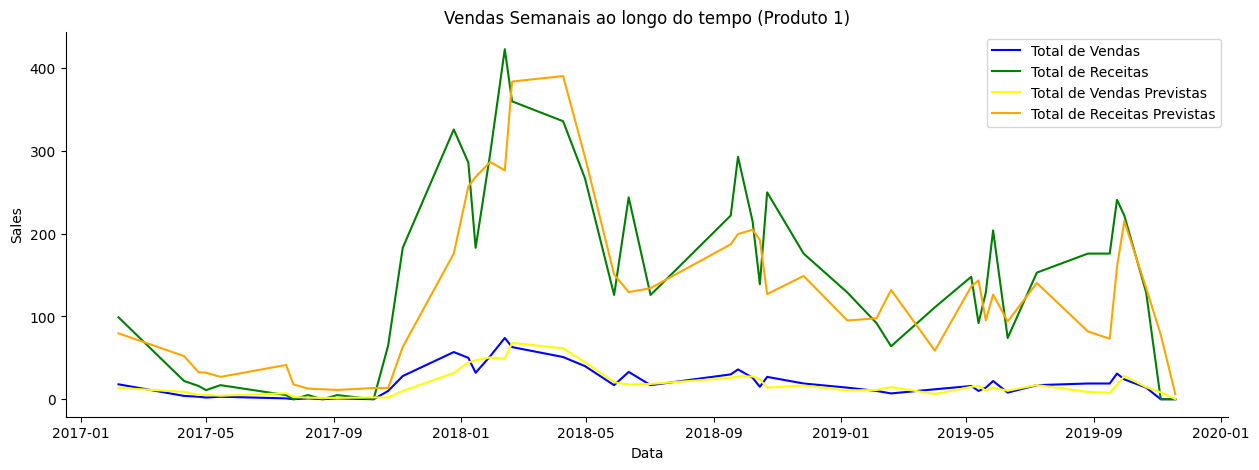

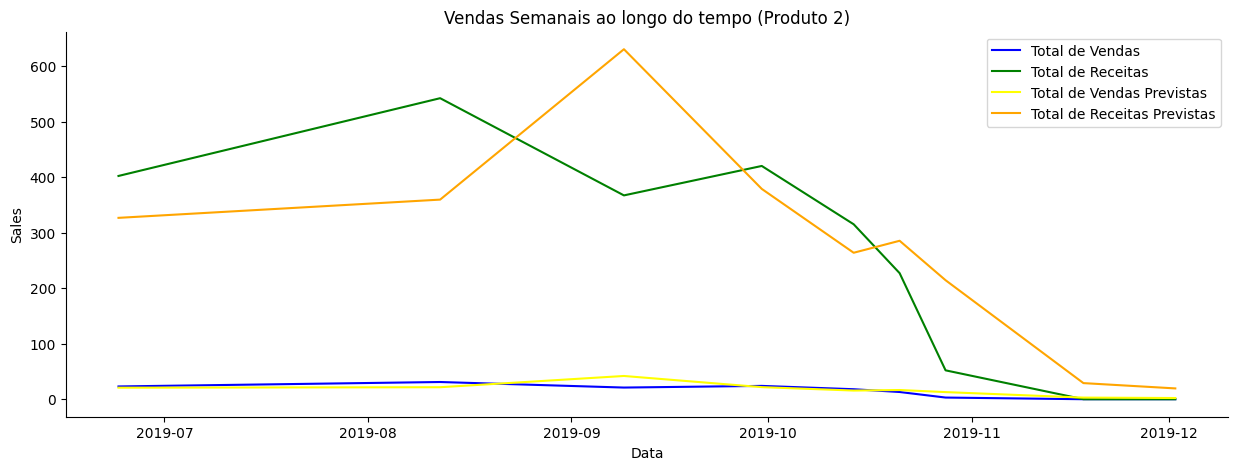

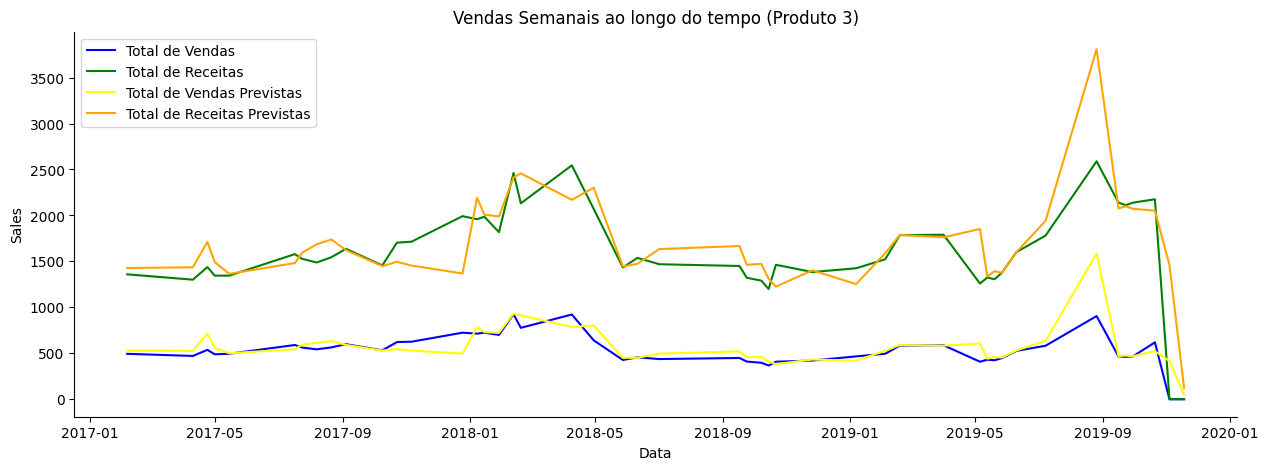

In [75]:
predict_model_no_opt(model)

---Após Otimização---

R2 Score das Vendas (Produto 1): 0.9992752406816376
R2 Score das Vendas (Produto 2): 1.0
R2 Score das Vendas (Produto 3): 0.9934528386277821
Média R2 Score das Vendas: 0.9975760264364734

R2 Score das Receitas (Produto 1): 0.9994678829537834
R2 Score das Receitas (Produto 2): 1.0
R2 Score das Receitas (Produto 3): 0.9958411649636876
Média R2 Score das Receitas: 0.9984363493058237


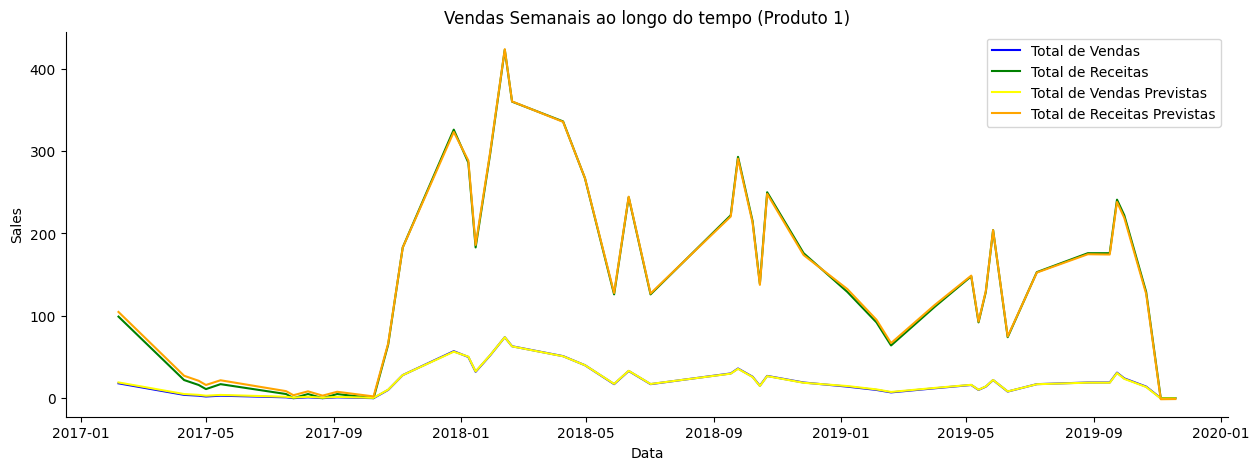

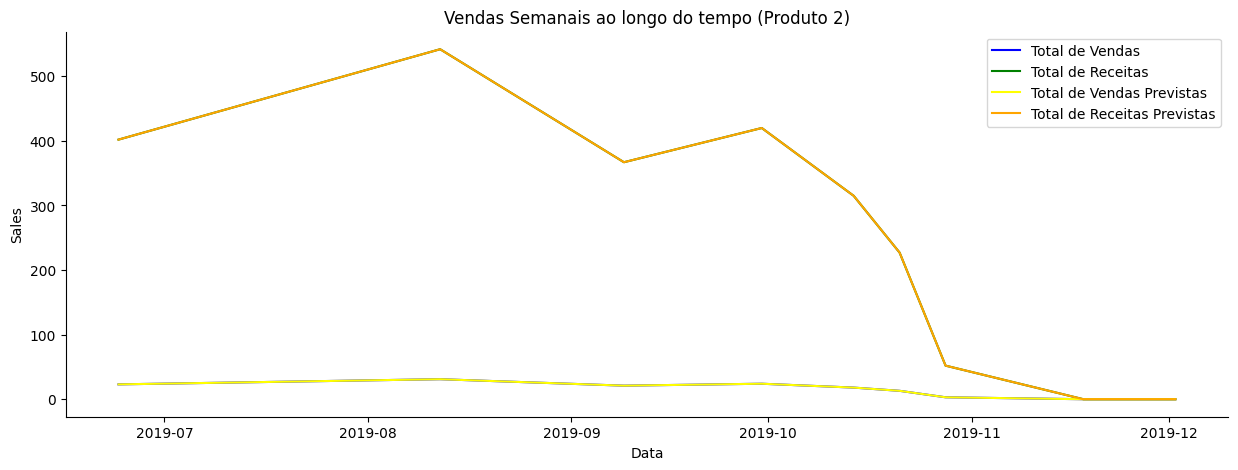

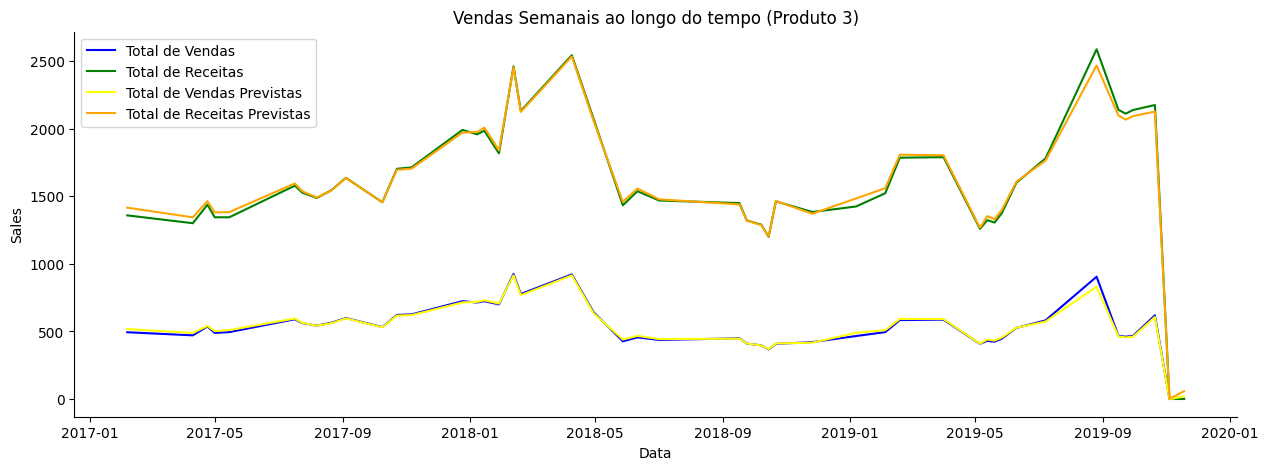

In [76]:
predict_model_opt(model)

In [87]:
modelResults, modelResults_optimized = pred_model_overall(model)

  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    8.640077     60.389758  0.773317    0.708043   6.258556   
0      P0002    1.811763    311.741265 -0.065962   -0.081558   0.735179   
0      P0004    2.242491      7.753222  0.374284    0.373777   1.823340   
0      P0005    3.156023    121.428400 -0.164780   -0.063538   2.552384   
0      P0006    2.764768     55.744054  0.246151    0.315635   1.520720   

   mae_revenue  
0    45.077264  
0   146.997148  
0     6.635863  
0    97.256782  
0    30.067417  
  product_id    rmse_sales  rmse_revenue  r2_sales  r2_revenue     mae_sales  \
0      P0001  4.885453e-01  2.578147e+00  0.999275    0.999468  4.041303e-01   
0      P0002  1.218277e-15  2.703535e-14  1.000000    1.000000  1.016386e-15   
0      P0004  1.701733e-01  6.039874e-01  0.996397    0.996200  1.130480e-01   
0      P0005  1.239025e-01  3.358133e+00  0.998205    0.999187  1.014305e-01   
0      P0006  7.875279e-02  2.066969e+00  0.999

In [88]:
print_model_results_no_opt(modelResults)


Média RMSE de Receitas: 68.8690899057531
Média RMSE de Vendas: 866.9738942922692
Média MAE de Receitas: 34.328260548278536
Média MAE de Vendas: 387.8972367030951
Média R2 Score  de Vendas: 0.30670079485857815
Média R2 Score de Receitas: 0.32413322245861886


In [89]:

print_model_results_opt(modelResults_optimized)

---Após Otimização---
Média RMSE de Receitas: 3.930319671829542
Média RMSE de Vendas: 23.50832170360352
Média MAE de Receitas: 3.0737592775482585
Média MAE de Vendas: 17.031017127568226
Média R2 Score de Vendas: 0.9913472859683569
Média R2 Score de Receitas: 0.9920820315118327


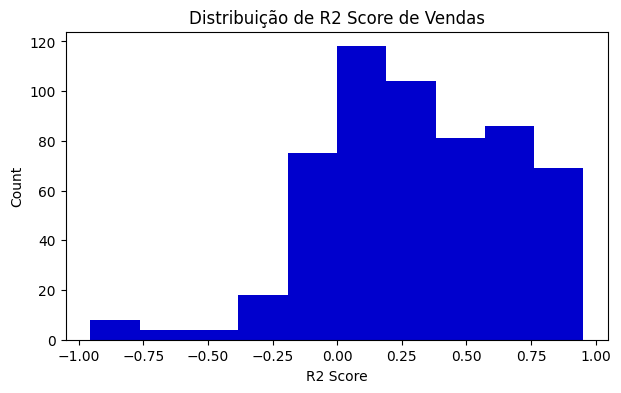

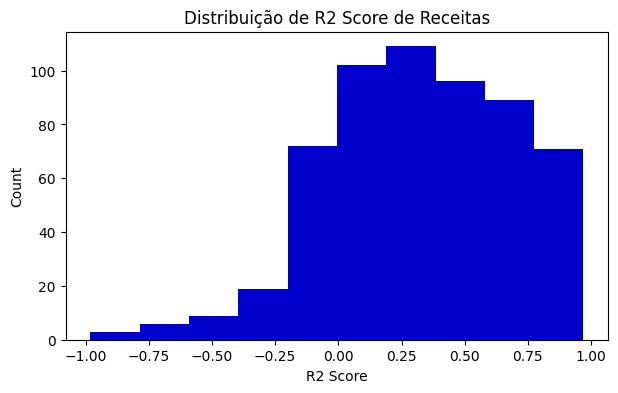

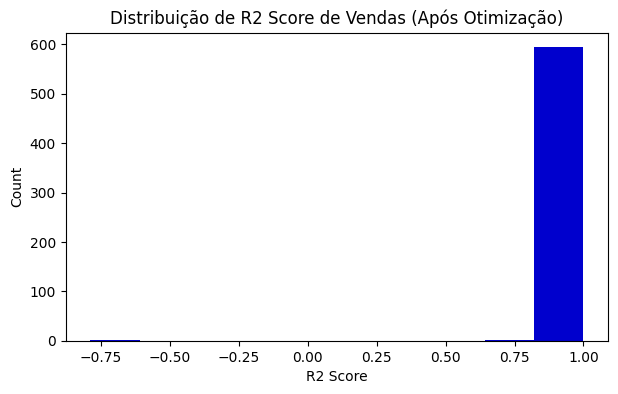

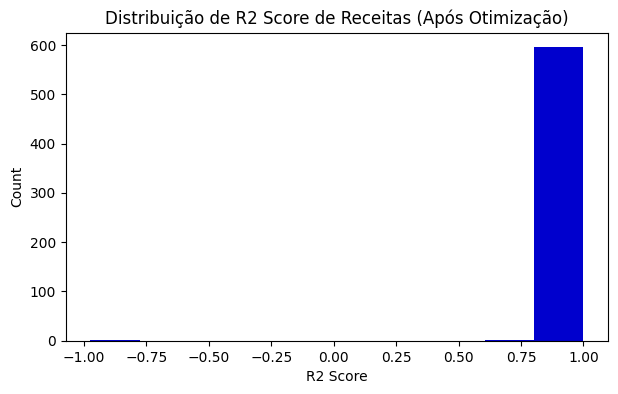

In [91]:

print_plot_results(modelResults,modelResults_optimized)



#  XGBoost

In [92]:

model = XGBRegressor(objective='reg:squarederror')

RMSE das Vendas (Produto 1): 8.886786459002023
RMSE das Vendas (Produto 2): 13.019116940683803
RMSE das Vendas (Produto 3): 128.9655382567886
Média RMSE das Vendas: 50.29048055215814

RMSE das Receitas (Produto 1): 63.51594477321163
RMSE das Receitas (Produto 2): 103.23331818027108
RMSE das Receitas (Produto 3): 350.2458864934886
Média RMSE das Receitas: 172.3317164823238

MAE das Vendas (Produto 1): 6.601216229986637
MAE das Vendas (Produto 2): 8.015560899030081
MAE das Vendas (Produto 3): 87.81267512986001
Média MAE das Vendas: 34.14315075295891

MAE das Receitas (Produto 1): 45.2821563863136
MAE das Receitas (Produto 2): 80.1170205104928
MAE das Receitas (Produto 3): 218.38816441880897
Média MAE das Receitas: 114.59578043853845

R2 Score das Vendas (Produto 1): 0.7601864606200515
R2 Score das Vendas (Produto 2): -0.46180684403015304
R2 Score das Vendas (Produto 3): 0.46242632178987697
Média R2 Score das Vendas: 0.25360197945992513

R2 Score das Receitas (Produto 1): 0.67703352710791

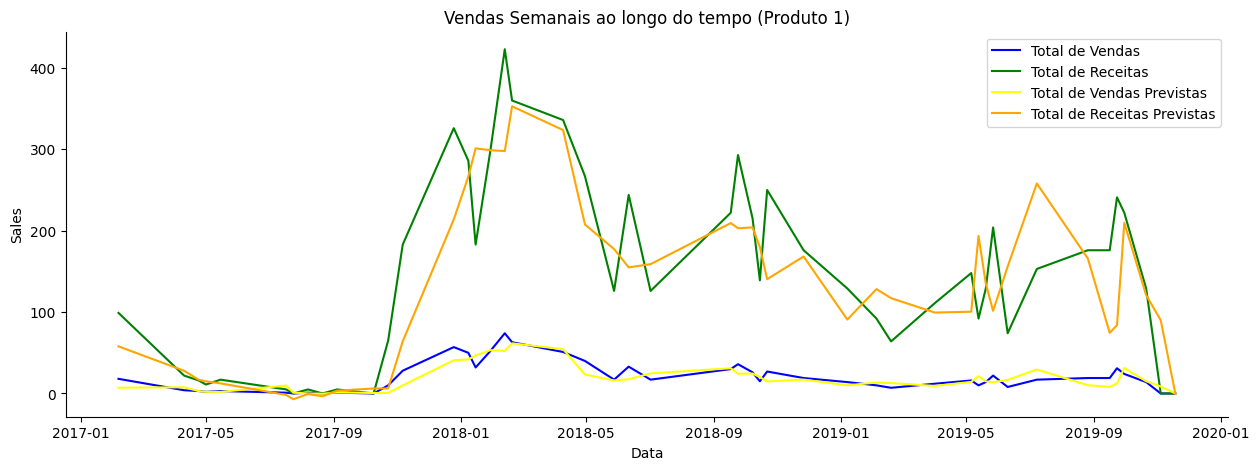

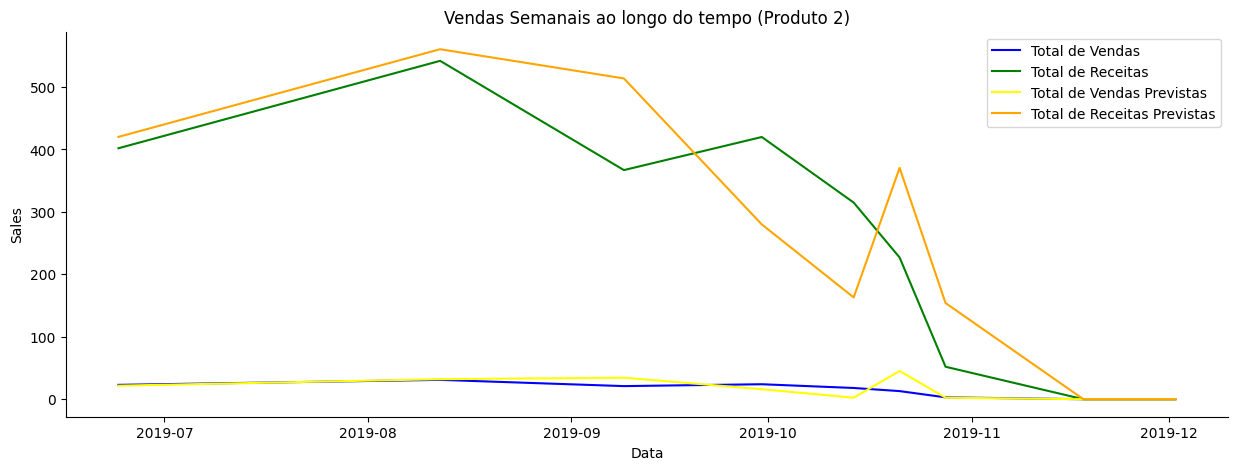

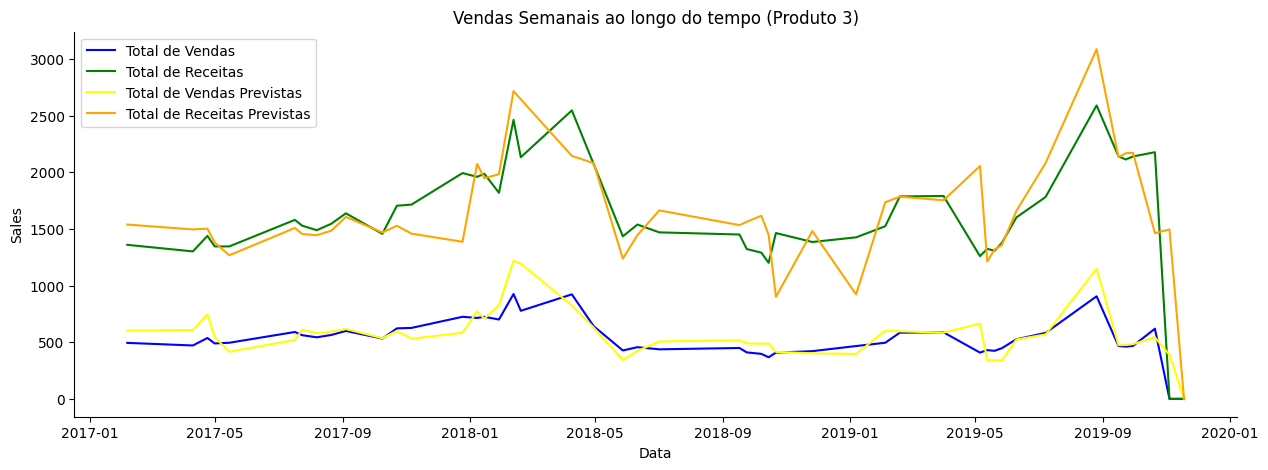

In [93]:
predict_model_no_opt(model)

---Após Otimização---

R2 Score das Vendas (Produto 1): 0.9532923607488103
R2 Score das Vendas (Produto 2): 0.7129260891616883
R2 Score das Vendas (Produto 3): 0.8321221306986455
Média R2 Score das Vendas: 0.8327801935363813

R2 Score das Receitas (Produto 1): 0.9420306974091036
R2 Score das Receitas (Produto 2): 0.8468905463540599
R2 Score das Receitas (Produto 3): 0.7941022282220509
Média R2 Score das Receitas: 0.8610078239950715


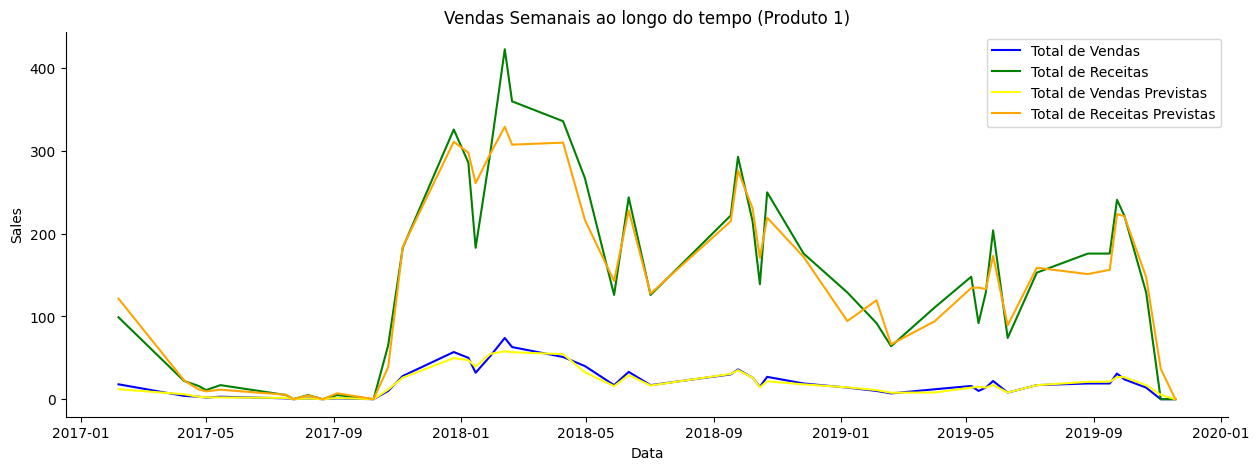

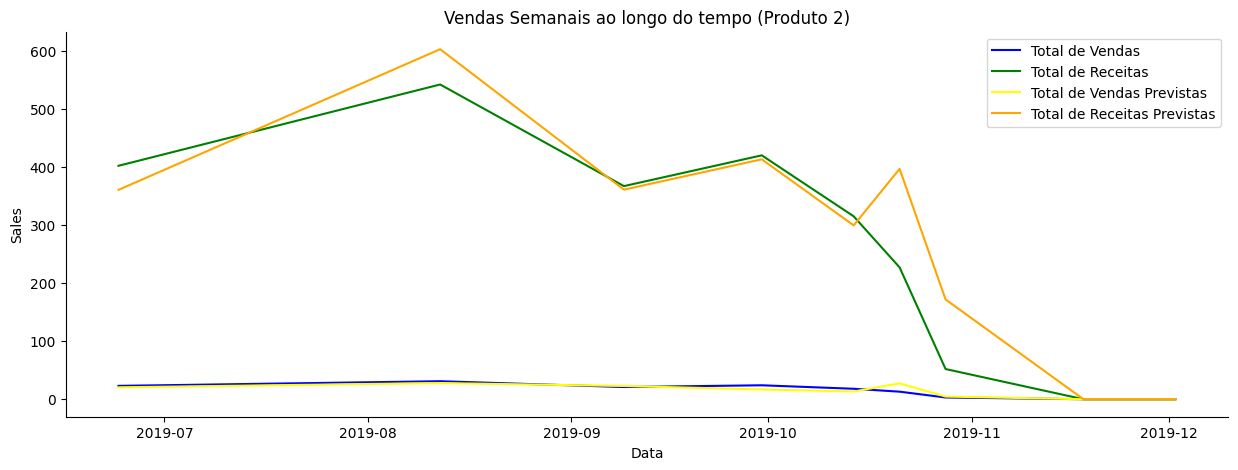

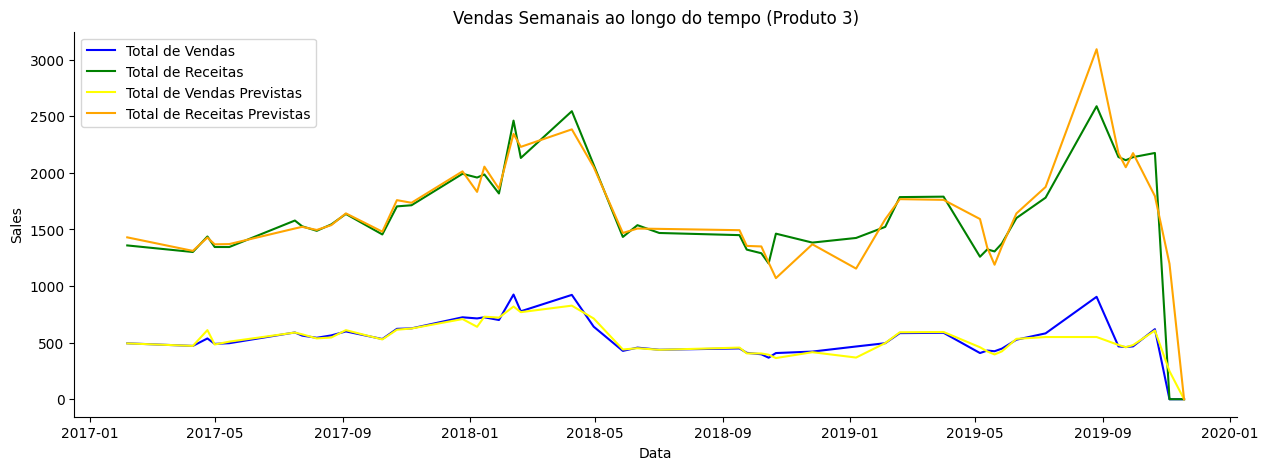

In [94]:
predict_model_opt(model)

In [95]:
modelResults, modelResults_optimized = pred_model_overall(model)

  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    8.886786     63.515945  0.760186    0.677034   6.601216   
0      P0002    1.903361    318.790390 -0.176471   -0.131023   0.832789   
0      P0004    3.061044     11.651905 -0.165883   -0.414355   2.139989   
0      P0005    3.266907    131.371372 -0.248065   -0.244841   2.580827   
0      P0006    3.097416     62.198891  0.053837    0.147968   1.649955   

   mae_revenue  
0    45.282156  
0   162.521318  
0     8.671870  
0   103.134937  
0    32.072424  
  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    3.921948     26.909342  0.953292    0.942031   2.526265   
0      P0002    1.281089    188.034727  0.467036    0.606507   0.318520   
0      P0004    2.005933      6.578718  0.499333    0.549134   0.973102   
0      P0005    0.887639     38.108813  0.907862    0.895248   0.610447   
0      P0006    1.579724     25.608584  0.753890    0.855569   0.527169 

In [96]:
print_model_results_no_opt(modelResults)

Média RMSE de Receitas: 74.60617733799236
Média RMSE de Vendas: 911.1256695051029
Média MAE de Receitas: 35.678157100641464
Média MAE de Vendas: 395.6120399587518
Média R2 Score  de Vendas: 0.1862354420118437
Média R2 Score de Receitas: 0.21103213354354816


In [97]:
print_model_results_opt(modelResults_optimized)

---Após Otimização---
Média RMSE de Receitas: 44.53083510245362
Média RMSE de Vendas: 695.1355484969347
Média MAE de Receitas: 18.825873067041165
Média MAE de Vendas: 277.4599057971463
Média R2 Score de Vendas: 0.7391042485166524
Média R2 Score de Receitas: 0.764808024562169


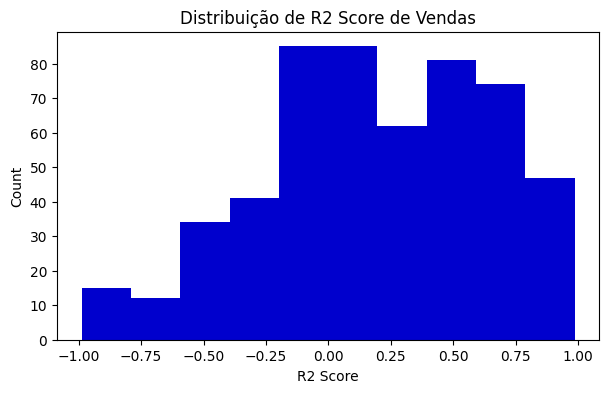

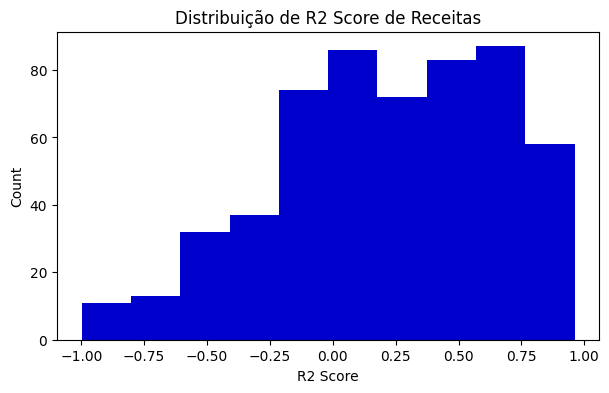

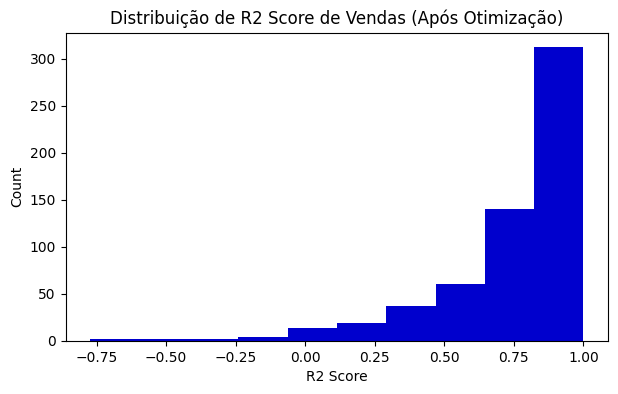

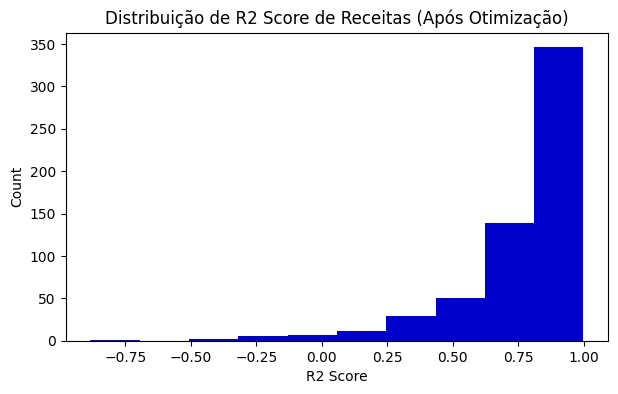

In [98]:
print_plot_results(modelResults,modelResults_optimized)

# RANDOM FOREST

RMSE das Vendas (Produto 1): 8.886786459002023
RMSE das Vendas (Produto 2): 13.019116940683803
RMSE das Vendas (Produto 3): 128.9655382567886
Média RMSE das Vendas: 50.29048055215814

RMSE das Receitas (Produto 1): 63.51594477321163
RMSE das Receitas (Produto 2): 103.23331818027108
RMSE das Receitas (Produto 3): 350.2458864934886
Média RMSE das Receitas: 172.3317164823238

MAE das Vendas (Produto 1): 6.601216229986637
MAE das Vendas (Produto 2): 8.015560899030081
MAE das Vendas (Produto 3): 87.81267512986001
Média MAE das Vendas: 34.14315075295891

MAE das Receitas (Produto 1): 45.2821563863136
MAE das Receitas (Produto 2): 80.1170205104928
MAE das Receitas (Produto 3): 218.38816441880897
Média MAE das Receitas: 114.59578043853845

R2 Score das Vendas (Produto 1): 0.7601864606200515
R2 Score das Vendas (Produto 2): -0.46180684403015304
R2 Score das Vendas (Produto 3): 0.46242632178987697
Média R2 Score das Vendas: 0.25360197945992513

R2 Score das Receitas (Produto 1): 0.67703352710791

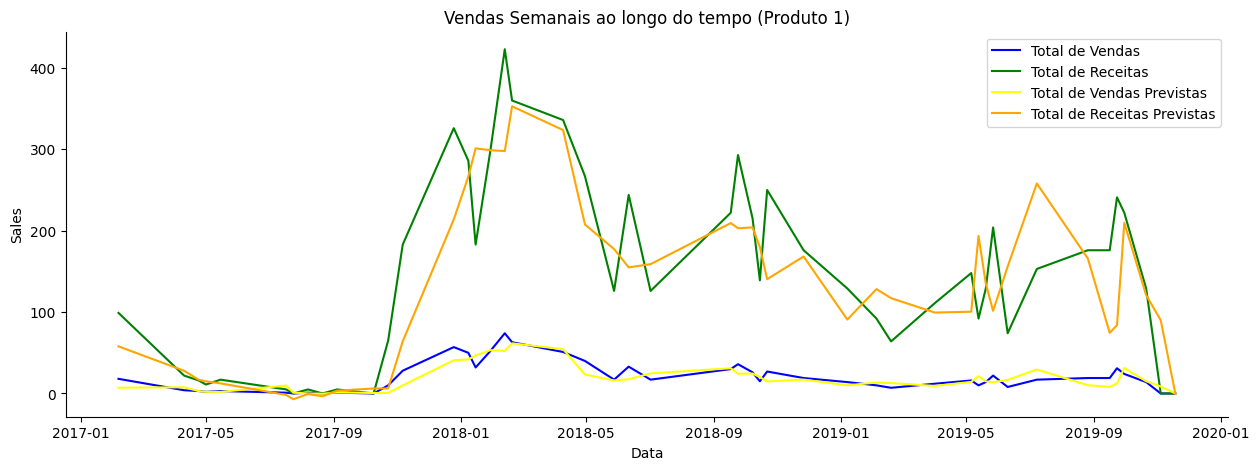

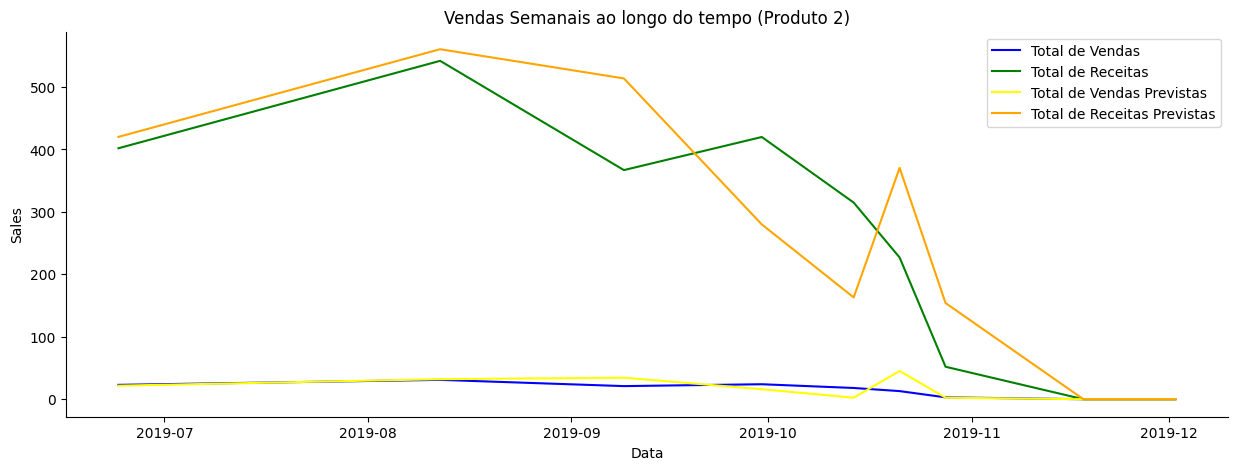

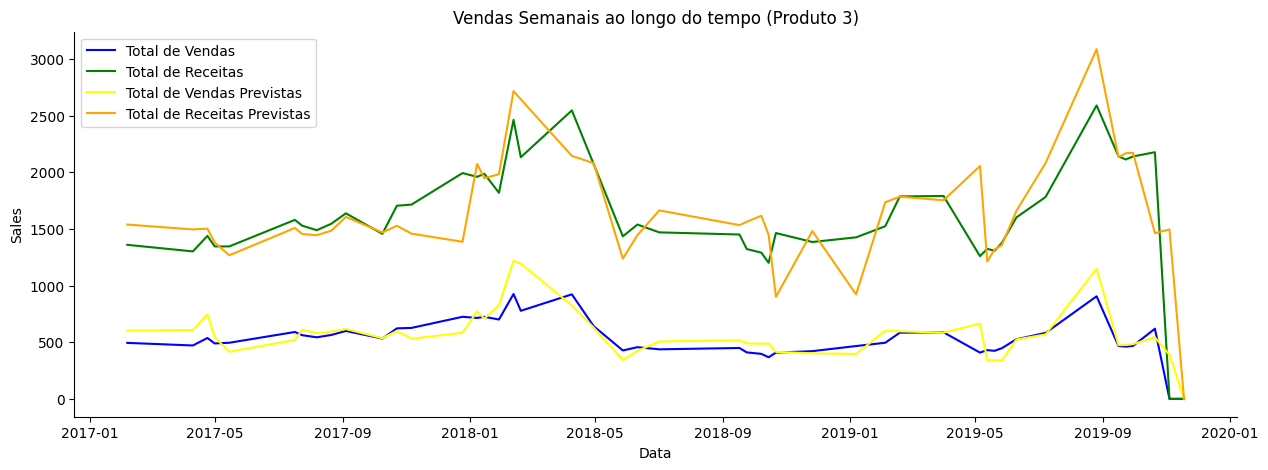

In [99]:
predict_model_no_opt(model)

---Após Otimização---

R2 Score das Vendas (Produto 1): 0.9532923607488103
R2 Score das Vendas (Produto 2): 0.7129260891616883
R2 Score das Vendas (Produto 3): 0.8321221306986455
Média R2 Score das Vendas: 0.8327801935363813

R2 Score das Receitas (Produto 1): 0.9420306974091036
R2 Score das Receitas (Produto 2): 0.8468905463540599
R2 Score das Receitas (Produto 3): 0.7941022282220509
Média R2 Score das Receitas: 0.8610078239950715


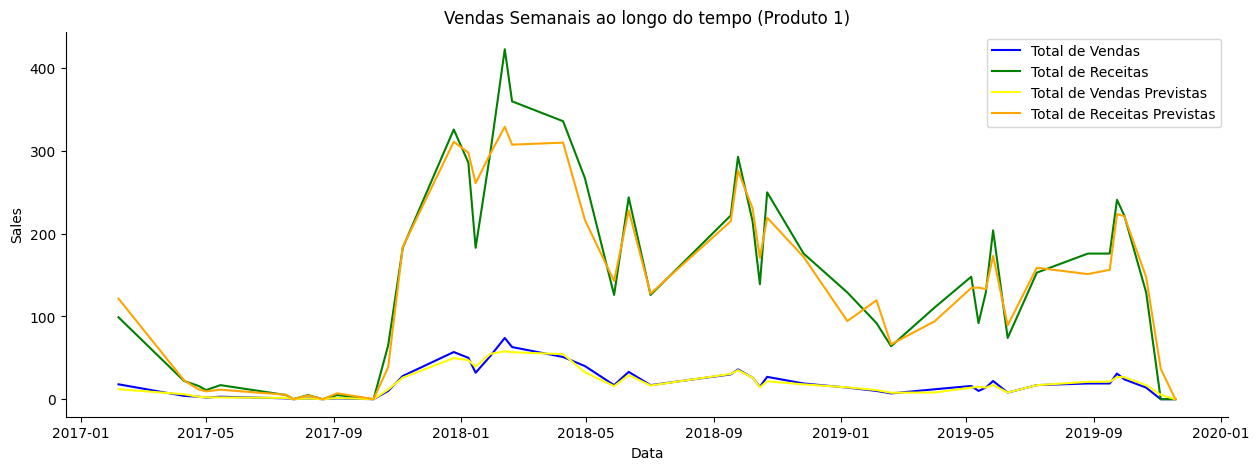

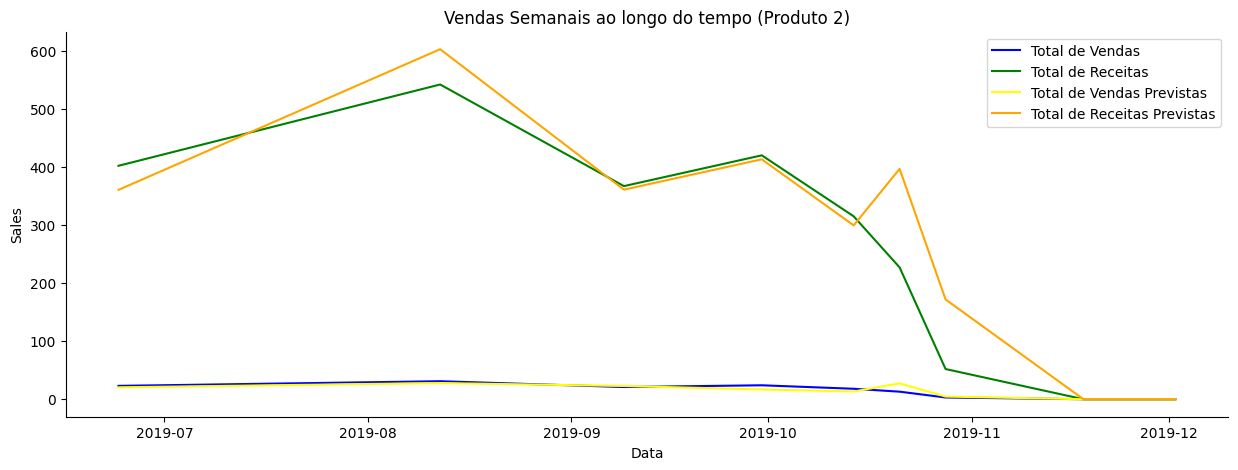

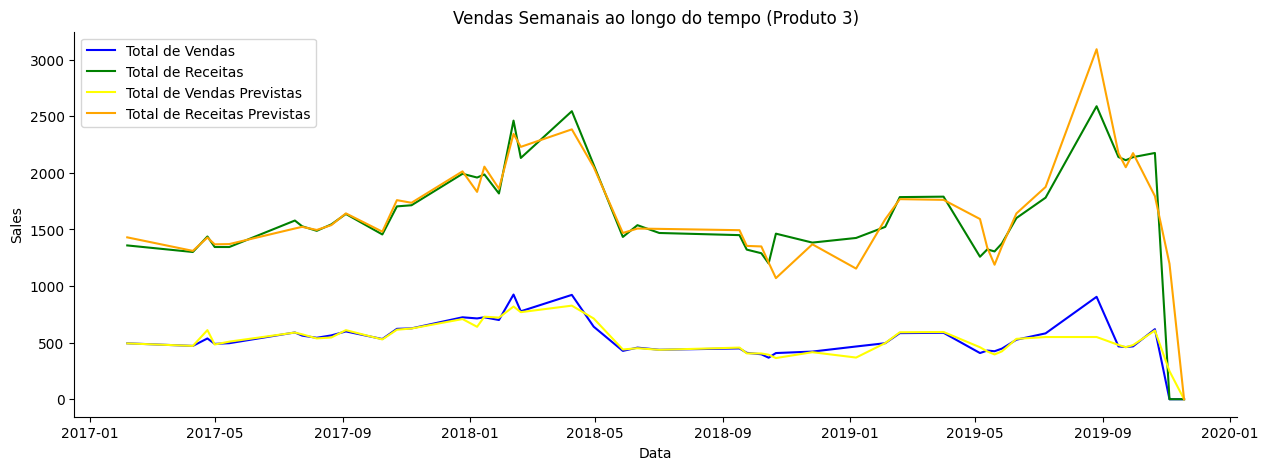

In [100]:
predict_model_opt(model)

In [101]:
modelResults, modelResults_optimized = pred_model_overall(model)

  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    8.886786     63.515945  0.760186    0.677034   6.601216   
0      P0002    1.903361    318.790390 -0.176471   -0.131023   0.832789   
0      P0004    3.061044     11.651905 -0.165883   -0.414355   2.139989   
0      P0005    3.266907    131.371372 -0.248065   -0.244841   2.580827   
0      P0006    3.097416     62.198891  0.053837    0.147968   1.649955   

   mae_revenue  
0    45.282156  
0   162.521318  
0     8.671870  
0   103.134937  
0    32.072424  
  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    3.921948     26.909342  0.953292    0.942031   2.526265   
0      P0002    1.281089    188.034727  0.467036    0.606507   0.318520   
0      P0004    2.005933      6.578718  0.499333    0.549134   0.973102   
0      P0005    0.887639     38.108813  0.907862    0.895248   0.610447   
0      P0006    1.579724     25.608584  0.753890    0.855569   0.527169 

In [102]:
print_model_results_no_opt(modelResults)

Média RMSE de Receitas: 74.60617733799236
Média RMSE de Vendas: 911.1256695051029
Média MAE de Receitas: 35.678157100641464
Média MAE de Vendas: 395.6120399587518
Média R2 Score  de Vendas: 0.1862354420118437
Média R2 Score de Receitas: 0.21103213354354816


In [103]:
print_model_results_opt(modelResults_optimized)

---Após Otimização---
Média RMSE de Receitas: 44.53083510245362
Média RMSE de Vendas: 695.1355484969347
Média MAE de Receitas: 18.825873067041165
Média MAE de Vendas: 277.4599057971463
Média R2 Score de Vendas: 0.7391042485166524
Média R2 Score de Receitas: 0.764808024562169


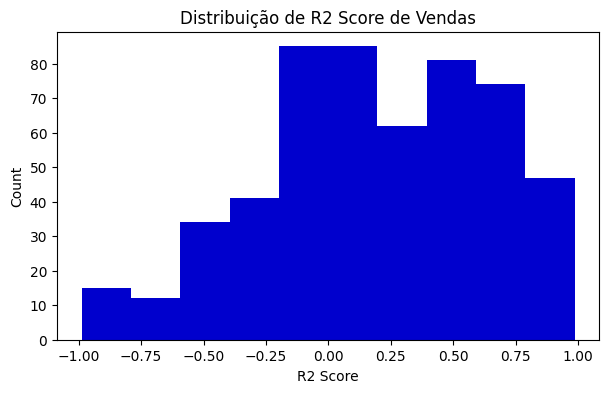

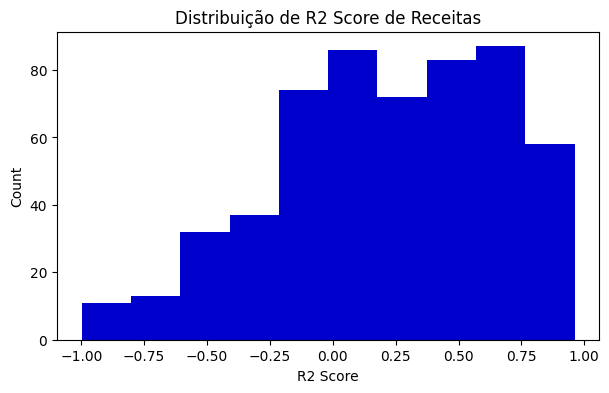

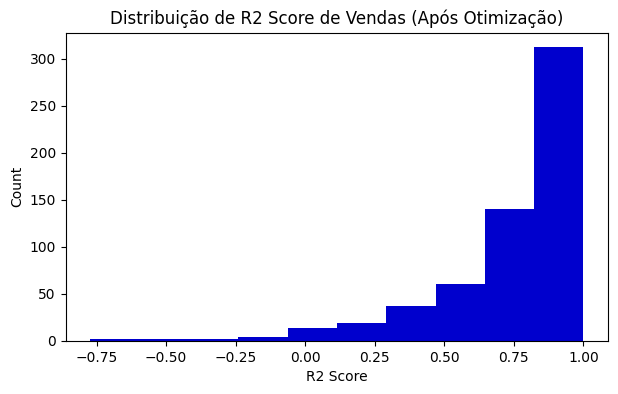

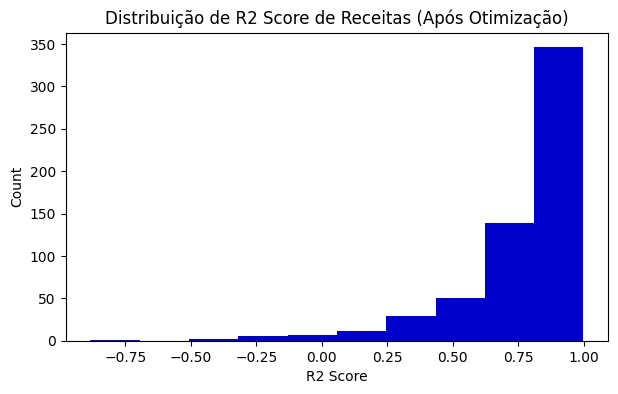

In [104]:
print_plot_results(modelResults,modelResults_optimized)

# LSTM

In [115]:
# Função de previsão, devolvendo as métricas de avaliação de desempenho dos modelos obtidos
def model_LSTM(X_train, y_train, X_test, y_test,n_var):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, n_var), stateful=False,return_sequences=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    y_pred = model.predict(X_test, batch_size=1)

    y_pred = np.squeeze(y_pred)
    # Calculamos o MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculamos o RMSE
    rmse = sqrt(mse)

    # Calculamos o MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculamos o R^2 score
    r2 = r2_score(y_test, y_pred)

    return y_pred, rmse, mae, r2

# Função total de previsão, recorrendo às funções de preparação e previsão
def predict_LSTM(dataframe, salesColsToDrop, revenueColsToDrop,nVar):
    # Removemos as colunas que não deverão ser utilizadas pelo modelo, sendo que estas poderão variar caso tenham sido aplicadas técnicas de otimização ao dataframe
    X_sales = dataframe.drop(columns = salesColsToDrop, axis = 1)
    y_sales = dataframe.sales
    X_revenue = dataframe.drop(columns = revenueColsToDrop, axis = 1)
    y_revenue = dataframe.revenue

    print(X_sales.columns)

    X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, train_size=0.7, random_state=1)
    X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, train_size=0.7, random_state=1)

    y_pred_sales, rmse_sales, mae_sales, r2_sales = model_LSTM(X_train_sales, y_train_sales, X_test_sales, y_test_sales,nVar)
    y_pred_revenue, rmse_revenue, mae_revenue, r2_revenue = model_LSTM(X_train_revenue, y_train_revenue, X_test_revenue, y_test_revenue,nVar)

    # Armazenamos os índices dos conjuntos de teste
    test_sales_index = X_test_sales.index
    test_revenue_index = X_test_revenue.index

    # Adicionamos os indíces aos valores previstos
    y_pred_sales_df = pd.DataFrame(y_pred_sales, index = test_sales_index, columns=['forecasted_sales'])
    y_pred_revenue_df = pd.DataFrame(y_pred_revenue, index = test_revenue_index, columns=['forecasted_revenue'])
    
    # Juntamos o dataframe original com o dataframe de valores previstos
    dataframe_with_forecast= pd.merge(dataframe, y_pred_sales_df, left_index=True, right_index=True, how='outer')
    dataframe_with_forecast = pd.merge(dataframe_with_forecast, y_pred_revenue_df, left_index=True, right_index=True, how='outer')

    return rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, dataframe_with_forecast


def print_predict_LSTM():
    salesColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue']
    revenueColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales']
    # Verificamos a variação do desempenho dos modelos de previsão em alguns produtos diferentes
    product_df_Test1_prep = prepareBeforePredict(product_df_Test1)
    product_df_Test2_prep = prepareBeforePredict(product_df_Test2)
    product_df_Test3_prep = prepareBeforePredict(product_df_Test3)
    print(product_df_Test3_prep.columns)
    rmse_sales1, rmse_revenue1, mae_sales1, mae_revenue1, r2_sales1, r2_revenue1, dataframe_with_forecast1 = predict_LSTM(product_df_Test1_prep, salesColsToDrop, revenueColsToDrop,3)
    rmse_sales2, rmse_revenue2, mae_sales2, mae_revenue2, r2_sales2, r2_revenue2, dataframe_with_forecast2 = predict_LSTM(product_df_Test2_prep, salesColsToDrop, revenueColsToDrop,3)
    rmse_sales3, rmse_revenue3, mae_sales3, mae_revenue3, r2_sales3, r2_revenue3, dataframe_with_forecast3 = predict_LSTM(product_df_Test3_prep,salesColsToDrop, revenueColsToDrop,3)

    print(f"RMSE das Vendas (Produto 1): {rmse_sales1}")
    print(f"RMSE das Vendas (Produto 2): {rmse_sales2}")
    print(f"RMSE das Vendas (Produto 3): {rmse_sales3}")
    print(f"Média RMSE das Vendas: {(rmse_sales1 + rmse_sales2 + rmse_sales3)/3}")
    print(f"\nRMSE das Receitas (Produto 1): {rmse_revenue1}")
    print(f"RMSE das Receitas (Produto 2): {rmse_revenue2}")
    print(f"RMSE das Receitas (Produto 3): {rmse_revenue3}")
    print(f"Média RMSE das Receitas: {(rmse_revenue1 + rmse_revenue2 + rmse_revenue3)/3}")
    print(f"\nMAE das Vendas (Produto 1): {mae_sales1}")
    print(f"MAE das Vendas (Produto 2): {mae_sales2}")
    print(f"MAE das Vendas (Produto 3): {mae_sales3}")
    print(f"Média MAE das Vendas: {(mae_sales1 + mae_sales2 + mae_sales3)/3}")
    print(f"\nMAE das Receitas (Produto 1): {mae_revenue1}")
    print(f"MAE das Receitas (Produto 2): {mae_revenue2}")
    print(f"MAE das Receitas (Produto 3): {mae_revenue3}")
    print(f"Média MAE das Receitas: {(mae_revenue1 + mae_revenue2 + mae_revenue3)/3}")
    print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
    print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
    print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
    print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
    print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
    print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
    print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
    print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")
    # Embora os resultados das previsões já sejam apresentados acima, aqui comparamos visualmente os valores previstos com os valores reais, permitindo
    # aferir de uma forma mais percetível a discrepância entre os mesmos.
    # É importante salientar que a linearidade não será, naturalmente, bem representada nestes gráficos, devido ao facto de o split de dados em conjuntos de teste e treino ter sido de forma aleatória,
    # não contínua, isto é, são apenas apresentados os dados referentes à amostra de testes, para efeitos de comparação com as previsões. 
    # A decisão de realizar o split desta forma, surge para evitar que o modelo se torne demasiado otimista para um determinado período contínuo, procurando mitigar a possibilidade de overfitting
    time_plot(dataframe_with_forecast1.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)', False, True)
    time_plot(dataframe_with_forecast2.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)', False, True)
    time_plot(dataframe_with_forecast3.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)', False, True)

def print_predict_LSTM_Optimized():
    salesColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue', 'diff_revenue']
    revenueColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales', 'diff_sales']

    # Verificamos a diferença do desempenho dos modelos de previsão após aplicação de técnicas de otimização
    product_df_Test1_prep = prepareBeforePredictOptimized(product_df_Test1)
    product_df_Test2_prep = prepareBeforePredictOptimized(product_df_Test2)
    product_df_Test3_prep = prepareBeforePredictOptimized(product_df_Test3)
    _, _, _, _, r2_sales1, r2_revenue1, dataframe_with_forecast1 = predict_LSTM(product_df_Test1_prep, salesColsToDrop_optimized, revenueColsToDrop_optimized,4)
    _, _, _, _, r2_sales2, r2_revenue2, dataframe_with_forecast2 = predict_LSTM(product_df_Test2_prep, salesColsToDrop_optimized, revenueColsToDrop_optimized,4)
    _, _, _, _, r2_sales3, r2_revenue3, dataframe_with_forecast3 = predict_LSTM(product_df_Test3_prep, salesColsToDrop_optimized, revenueColsToDrop_optimized,4)

    print(f"---Após Otimização---")
    print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
    print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
    print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
    print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
    print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
    print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
    print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
    print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")
    # Embora os resultados das previsões já sejam apresentados acima, aqui comparamos visualmente os valores previstos com os valores reais, permitindo
    # aferir de uma forma mais percetível a discrepância entre os mesmos.
    # É importante salientar que a linearidade não será, naturalmente, bem representada nestes gráficos, devido ao facto de o split de dados em conjuntos de teste e treino ter sido de forma aleatória,
    # não contínua, isto é, são apenas apresentados os dados referentes à amostra de testes, para efeitos de comparação com as previsões. 
    # A decisão de realizar o split desta forma, surge para evitar que o modelo se torne demasiado otimista para um determinado período contínuo, procurando mitigar a possibilidade de overfitting
    time_plot(dataframe_with_forecast1.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)', False, True)
    time_plot(dataframe_with_forecast2.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)', False, True)
    time_plot(dataframe_with_forecast3.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)', False, True)

def pred_model_overall_LSTM(model):
    salesColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue']
    revenueColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales']
    salesColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue', 'diff_revenue']
    revenueColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales', 'diff_sales']
    
    # Criamos um dataframe onde serão armazenados os resultados dos modelos obtidos para posterior análise/comparação
    modelResults = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])
    modelResults_optimized = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])

    # Iteramos a lista de dataframes, treinando um modelo para cada produto e armazenando os respetivos resultados
    for name, group in dfByProdList:
        group_prep = prepareBeforePredict(group)
        group_prep_optimized = prepareBeforePredictOptimized(group)
        
        if(len(group_prep.sales.unique()) > 4) & (len(group_prep.revenue.unique()) > 4):
            rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue,_,_,_ = predict_LSTM(group_prep, salesColsToDrop, revenueColsToDrop,3)

            modelResults = pd.concat([modelResults,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, 
                "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])

            rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue,_,_,_ = predict_LSTM(group_prep_optimized, model, salesColsToDrop_optimized, revenueColsToDrop_optimized,4)

            modelResults_optimized = pd.concat([modelResults_optimized,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, 
                "mae_sales": mae_sales, "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])
        

    print(modelResults.head())
    print(modelResults_optimized.head())
    
                
    return modelResults,modelResults_optimized


In [111]:
print_predict_LSTM()

Index(['product_id', 'year', 'week', 'sales', 'revenue', 'stock', 'price',
       'date', 'prev_sales', 'prev_revenue'],
      dtype='object')
Index(['year', 'week', 'prev_sales'], dtype='object')
Epoch 1/200
109/109 [==============================] - 2s 1ms/step - loss: 648.9054
Epoch 2/200
109/109 [==============================] - 0s 1ms/step - loss: 640.3770
Epoch 3/200
109/109 [==============================] - 0s 1ms/step - loss: 630.4722
Epoch 4/200
109/109 [==============================] - 0s 1ms/step - loss: 618.3664
Epoch 5/200
109/109 [==============================] - 0s 1ms/step - loss: 603.0172
Epoch 6/200
109/109 [==============================] - 0s 1ms/step - loss: 583.2560
Epoch 7/200
109/109 [==============================] - 0s 1ms/step - loss: 558.9796
Epoch 8/200
109/109 [==============================] - 0s 1ms/step - loss: 531.3385
Epoch 9/200
109/109 [==============================] - 0s 1ms/step - loss: 501.6664
Epoch 10/200
109/109 [=========================

Index(['year', 'week', 'prev_sales', 'diff_sales'], dtype='object')
Epoch 1/200
109/109 [==============================] - 1s 1ms/step - loss: 655.4507
Epoch 2/200
109/109 [==============================] - 0s 1ms/step - loss: 648.0990
Epoch 3/200
109/109 [==============================] - 0s 1ms/step - loss: 640.1851
Epoch 4/200
109/109 [==============================] - 0s 1ms/step - loss: 630.2890
Epoch 5/200
109/109 [==============================] - 0s 1ms/step - loss: 617.5829
Epoch 6/200
109/109 [==============================] - 0s 1ms/step - loss: 601.6845
Epoch 7/200
109/109 [==============================] - 0s 1ms/step - loss: 582.4055
Epoch 8/200
109/109 [==============================] - 0s 1ms/step - loss: 559.7296
Epoch 9/200
109/109 [==============================] - 0s 1ms/step - loss: 533.8513
Epoch 10/200
109/109 [==============================] - 0s 1ms/step - loss: 505.3443
Epoch 11/200
109/109 [==============================] - 0s 1ms/step - loss: 475.1534
Epoch 

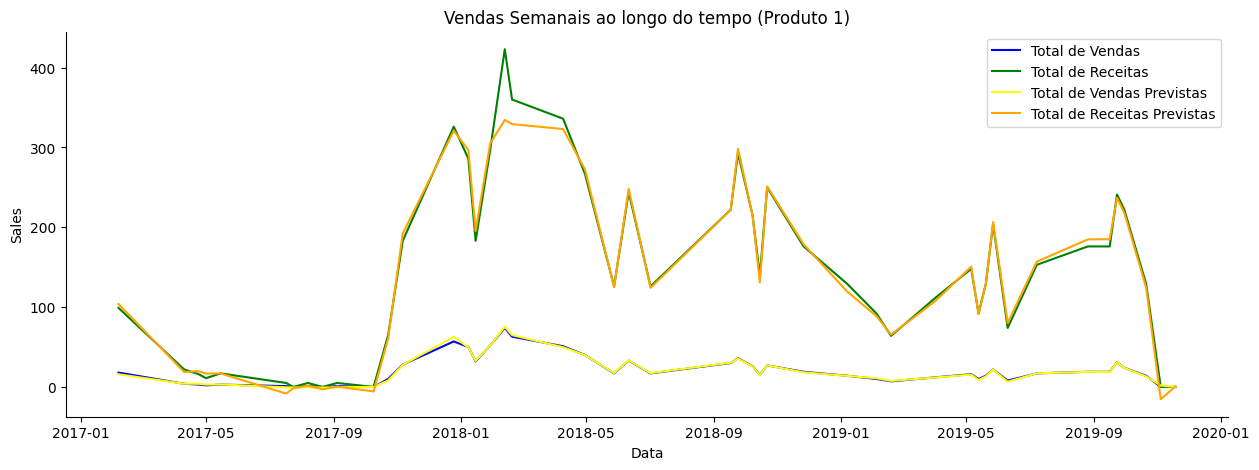

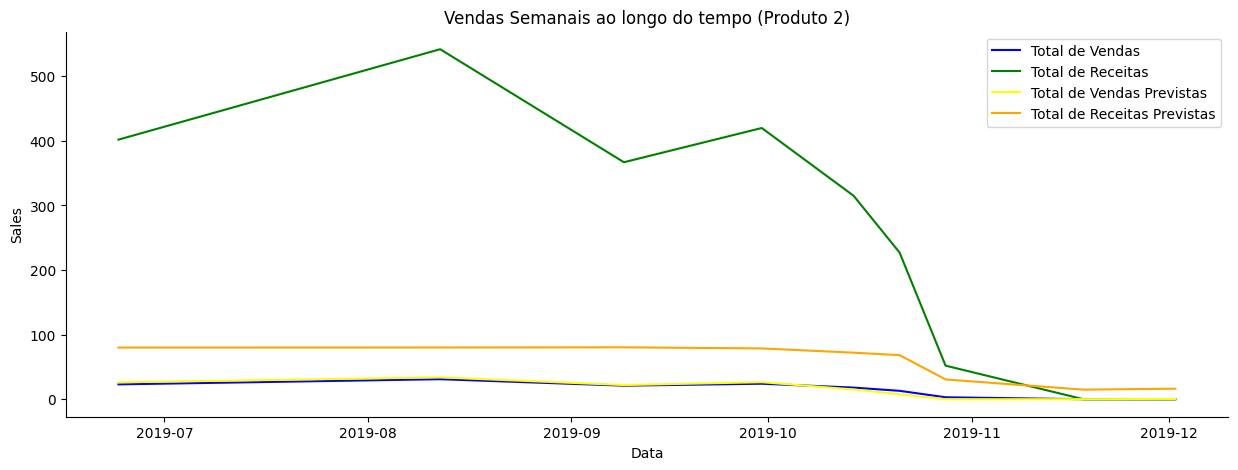

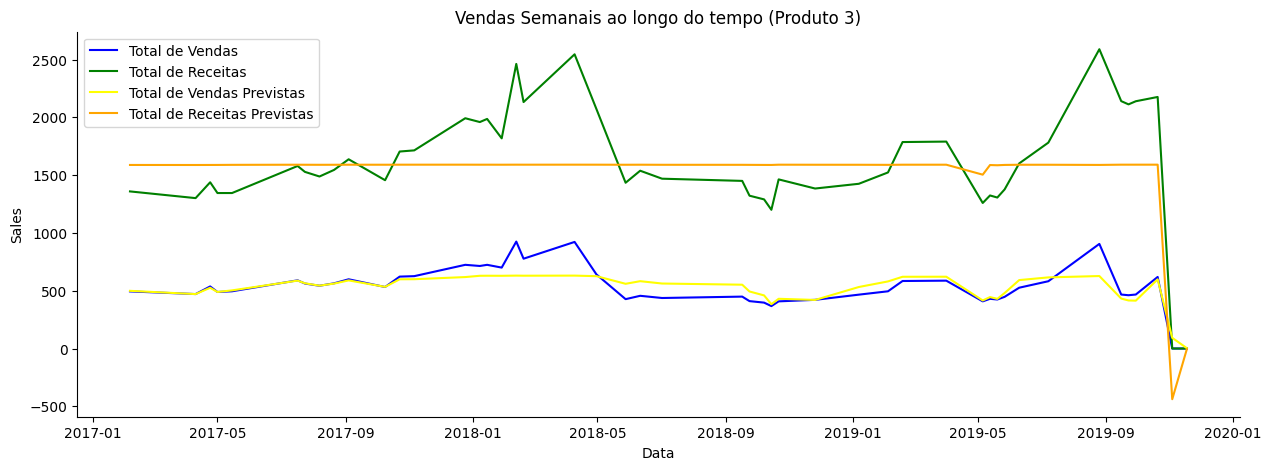

In [116]:
print_predict_LSTM_Optimized()

In [101]:

# Finalmente, utilizamos novamente os modelos otimizados para prever o total de unidades vendidas e o total de receitas na periodicidade de reposicionamento de stock escolhida

# Perguntamos pela periodicidade (em semanas) do reposicionamento de stock, para o qual serão efetuadas as previsões a ser utilizadas no modelo de otimização
periodicity = 0
while True:
    try:
        periodicity = int(input("Insira a periodicidade de Reposicionamento de Stock (em semanas): "))
        break
    except:
        print("Valor inválido, insira um valor inteiro!")

modelsList = [
    { 'model_name': 'LinearRegression', 'model': LinearRegression() }, 
    { 'model_name': 'RandomForestRegressor', 'model': RandomForestRegressor(n_estimators=100, max_depth=20) }, 
    { 'model_name': 'XGBRegressor', 'model': XGBRegressor(objective='reg:squarederror') }
]
finalResults = pd.DataFrame(columns=["product_id", "model", "rmse_sales", "rmse_revenue", "mae_sales", "mae_revenue", "r2_sales", "r2_revenue", "periodicity_total_pred_sales", "periodicity_total_pred_revenue"])
for name, group in dfByProdList:
    group_prep_optimized = prepareBeforePredictOptimized(group)
    
    if(len(group_prep_optimized.sales.unique()) > 4) & (len(group_prep_optimized.revenue.unique()) > 4):
        for currModel in modelsList:
            rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, _, periodicity_total_pred_sales, periodicity_total_pred_revenue = predict(group_prep_optimized, currModel['model'], salesColsToDrop_optimized, revenueColsToDrop_optimized, periodicity)

            finalResults = pd.concat([finalResults,  pd.DataFrame.from_records([{"product_id": name, "model": currModel['model_name'], "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, 
                "mae_sales": mae_sales, "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue, 
                "periodicity_total_pred_sales": periodicity_total_pred_sales, "periodicity_total_pred_revenue": periodicity_total_pred_revenue}])])
    

print(finalResults.head())

  product_id                  model    rmse_sales  rmse_revenue     mae_sales  \
0      P0001       LinearRegression  4.885453e-01  2.578147e+00  4.041303e-01   
0      P0001  RandomForestRegressor  4.541629e+00  2.643378e+01  2.912128e+00   
0      P0001           XGBRegressor  3.921948e+00  2.690934e+01  2.526265e+00   
0      P0002       LinearRegression  1.218277e-15  2.703535e-14  1.016386e-15   
0      P0002  RandomForestRegressor  1.381411e+00  2.095142e+02  3.619048e-01   

    mae_revenue  r2_sales  r2_revenue  periodicity_total_pred_sales  \
0  2.147004e+00  0.999275    0.999468                     19.387474   
0  1.623660e+01  0.937366    0.944062                     31.180000   
0  1.796265e+01  0.953292    0.942031                     31.250749   
0  1.974587e-14  1.000000    1.000000                      1.000000   
0  6.351167e+01  0.380296    0.511473                      0.000000   

   periodicity_total_pred_revenue  
0                      196.859264  
0             

In [120]:


# Exportamos os resultados finais obtidos, incluindo as previsões de vendas e receitas de cada produto para a periodicidade escolhida.
finalResults = finalResults.reset_index(drop=True)
finalResults.periodicity_total_pred_sales = finalResults.periodicity_total_pred_sales.apply(lambda x: max(0, math.ceil(x))).astype(int)
finalResults.periodicity_total_pred_revenue = finalResults.periodicity_total_pred_revenue.apply(lambda x: max(0, math.ceil(x * 100)) / 100).round(2)
finalResults.to_excel('./results/results.xlsx', index=False)

